## Setup

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
!nvidia-smi

Sun Apr 27 22:37:34 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P0             47W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [ ]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


### Imports

In [ ]:
import torch
import torchvision
import os
import requests
import json
import cv2
import numpy as np
from PIL import Image, ImageOps
from torchvision import transforms
import torch
from transformers import CLIPProcessor, CLIPModel
from torchvision import transforms
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from diffusers import StableDiffusionPipeline

In [ ]:
# Define the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
dinov2_vitl14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14') # Loading the Large DINO Backbone/feature extractor

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitl14/dinov2_vitl14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vitl14_pretrain.pth
100%|██████████| 1.13G/1.13G [00:05<00:00, 220MB/s]


In [ ]:
# Load Stable Diffusion pipeline (you might need to adjust the model name)
pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5").to(device)
pipe.set_progress_bar_config(disable=True) # Suppress progress bar

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
def visualize_bbox(image_path, gt_bbox):
    """
    Visualizes the bounding box on an image using the AP-10K format.

    Parameters:
    - image_path (str): Path to the image file.
    - gt_bbox (list): Bounding box in AP-10K format [x_min, y_min, width, height].
    """
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct visualization

    # Extract bbox parameters
    x_min, y_min, width, height = gt_bbox

    # Draw the bounding box
    cv2.rectangle(image, (x_min, y_min), (x_min + width, y_min + height), color=(255, 0, 0), thickness=2)

    # Display the image
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.axis("off")
    plt.title("Bounding Box Visualization")
    plt.show()

In [ ]:
def create_keypoint_mask(image_shape, keypoints, num_keypoints):
    """
    Create a mask based on keypoints.

    Args:
    - image_shape: (height, width) of the original image
    - keypoints: Flat list of keypoints [x1, y1, v1, x2, y2, v2, ...]
    - num_keypoints: Number of keypoints

    Returns:
    - Numpy boolean mask
    """
    # Create an empty mask
    mask = np.zeros(image_shape[:2], dtype=np.uint8)

    # Process keypoints (every 3rd value is visibility)
    for i in range(num_keypoints):
        x = keypoints[i*3]
        y = keypoints[i*3 + 1]
        visibility = keypoints[i*3 + 2]

        # Only consider visible keypoints (visibility = 2)
        if visibility == 2:
            # Create a small circular region around each keypoint
            cv2.circle(mask, (x, y), radius=15, color=255, thickness=-1)

    # Dilate the mask to connect nearby keypoints
    kernel = np.ones((50, 50), np.uint8)
    mask = cv2.dilate(mask, kernel, iterations=1)

    return mask > 0


In [ ]:
transform = transforms.Compose([
                                transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(
                                mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225]
                                )])


transform1 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Transform image for CLIP
clip_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # CLIP expects 224x224 input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                         std=[0.26862954, 0.26130258, 0.27577711])  # CLIP normalization
])

{1: 'antelope', 2: 'argali sheep', 3: 'bison', 4: 'buffalo', 5: 'cow', 6: 'sheep', 7: 'arctic fox', 8: 'dog', 9: 'fox', 10: 'wolf', 11: 'beaver', 12: 'alouatta', 13: 'monkey', 14: 'noisy night monkey', 15: 'spider monkey', 16: 'uakari', 17: 'deer', 18: 'moose', 19: 'hamster', 20: 'elephant', 21: 'horse', 22: 'zebra', 23: 'bobcat', 24: 'cat', 25: 'cheetah', 26: 'jaguar', 27: 'king cheetah', 28: 'leopard', 29: 'lion', 30: 'panther', 31: 'snow leopard', 32: 'tiger', 33: 'giraffe', 34: 'hippo', 35: 'chimpanzee', 36: 'gorilla', 37: 'orangutan', 38: 'rabbit', 39: 'skunk', 40: 'mouse', 41: 'rat', 42: 'otter', 43: 'weasel', 44: 'raccoon', 45: 'rhino', 46: 'marmot', 47: 'squirrel', 48: 'pig', 49: 'mole', 50: 'black bear', 51: 'brown bear', 52: 'panda', 53: 'polar bear', 54: 'bat'}
First features for this species has dimensions of torch.Size([1, 3730500])
First image for jaguar with size (840, 840)


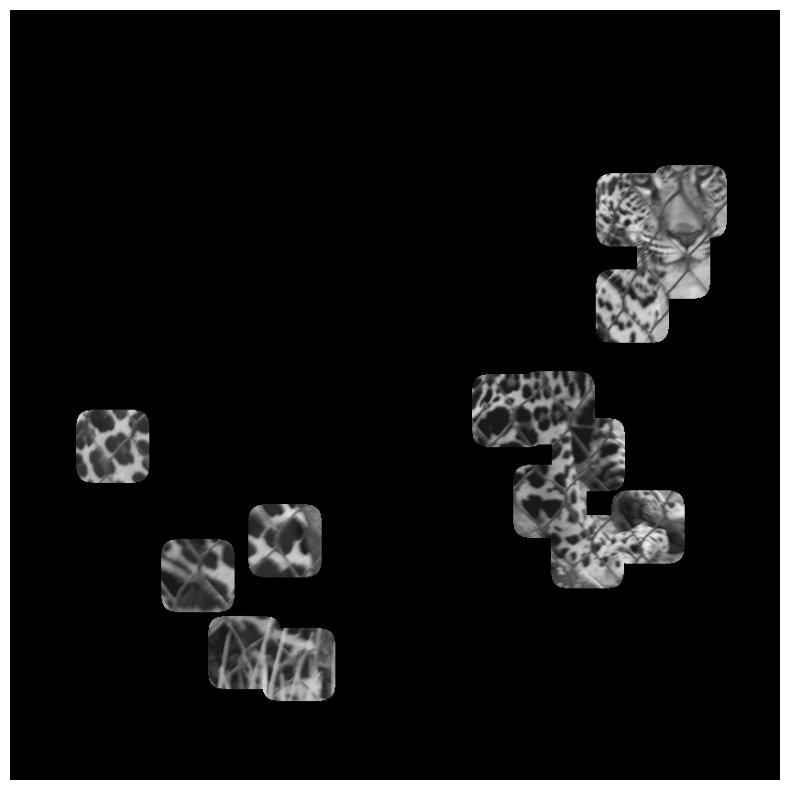

First features for this species has dimensions of torch.Size([1, 3730500])
First image for leopard with size (840, 840)


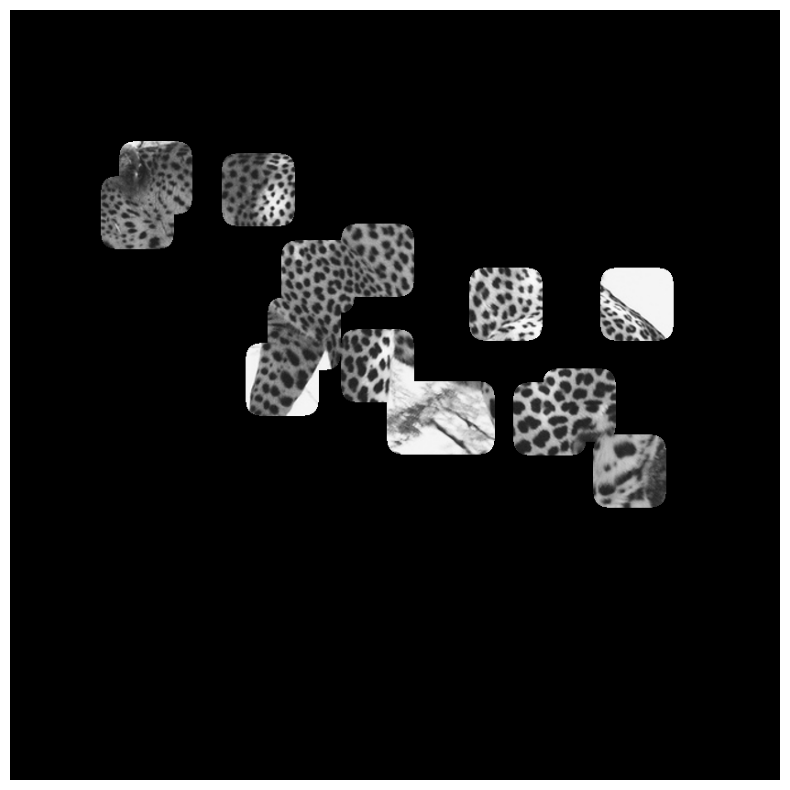

Have Generated Features for 100 Images.
First features for this species has dimensions of torch.Size([1, 3730500])
First image for cat with size (840, 840)


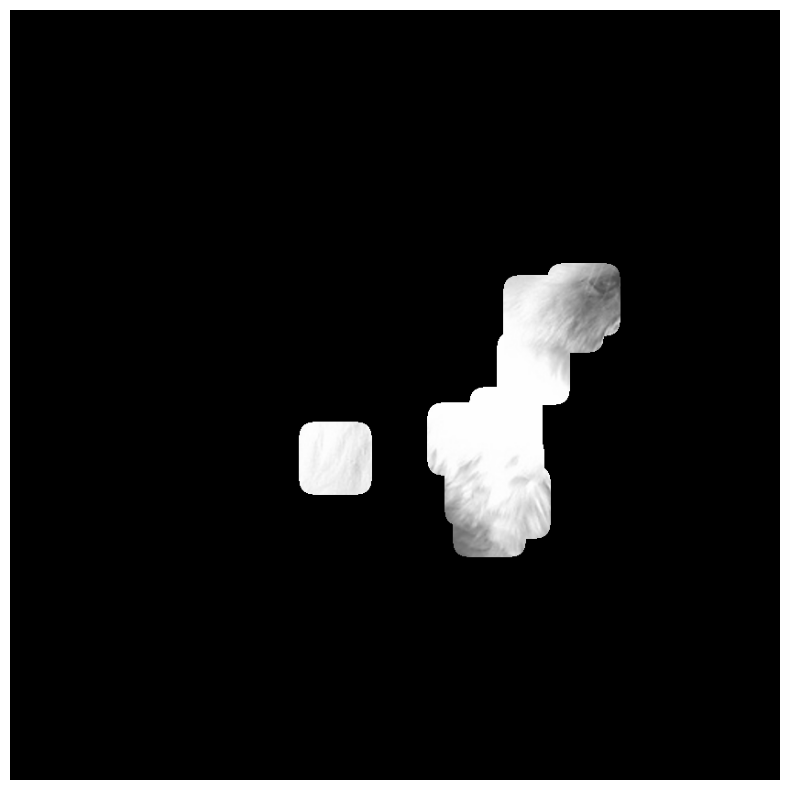

First features for this species has dimensions of torch.Size([1, 3730500])
First image for tiger with size (840, 840)


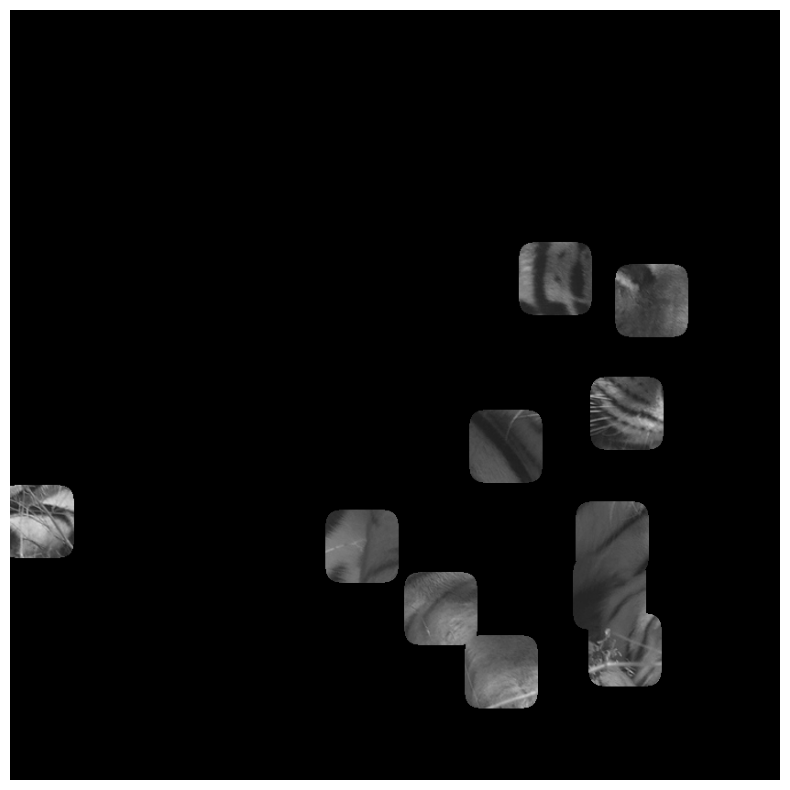

First features for this species has dimensions of torch.Size([1, 3730500])
First image for giraffe with size (840, 840)


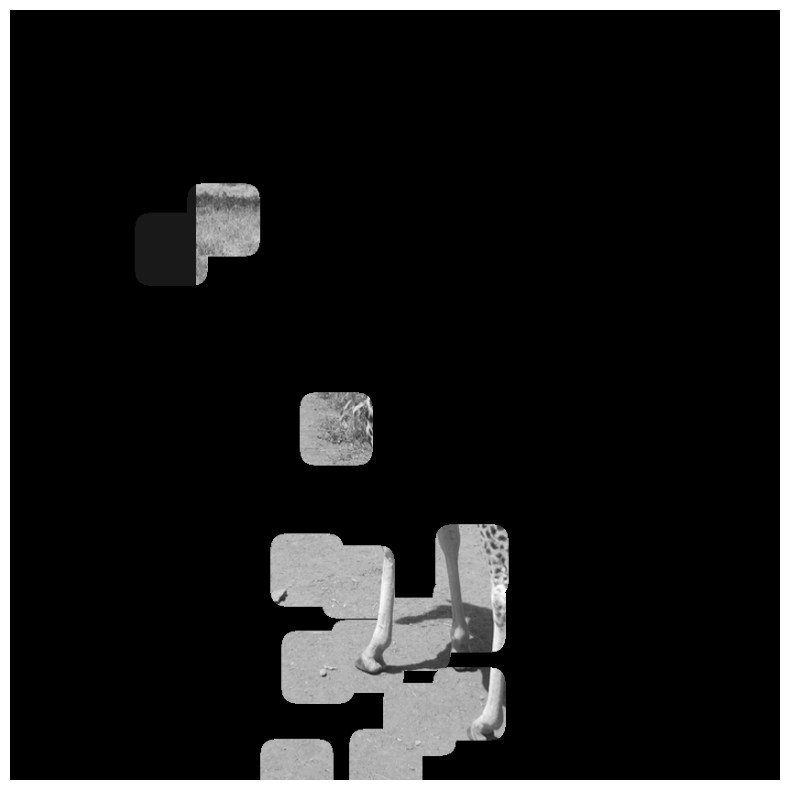

Have Generated Features for 200 Images.
First features for this species has dimensions of torch.Size([1, 3730500])
First image for hippo with size (840, 840)


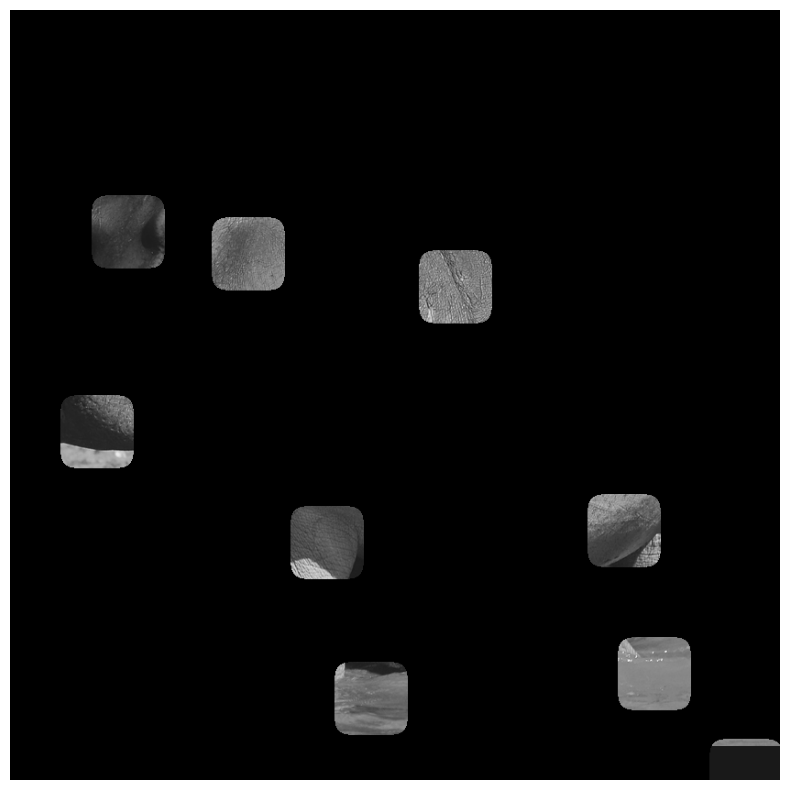

First features for this species has dimensions of torch.Size([1, 3730500])
First image for chimpanzee with size (840, 840)


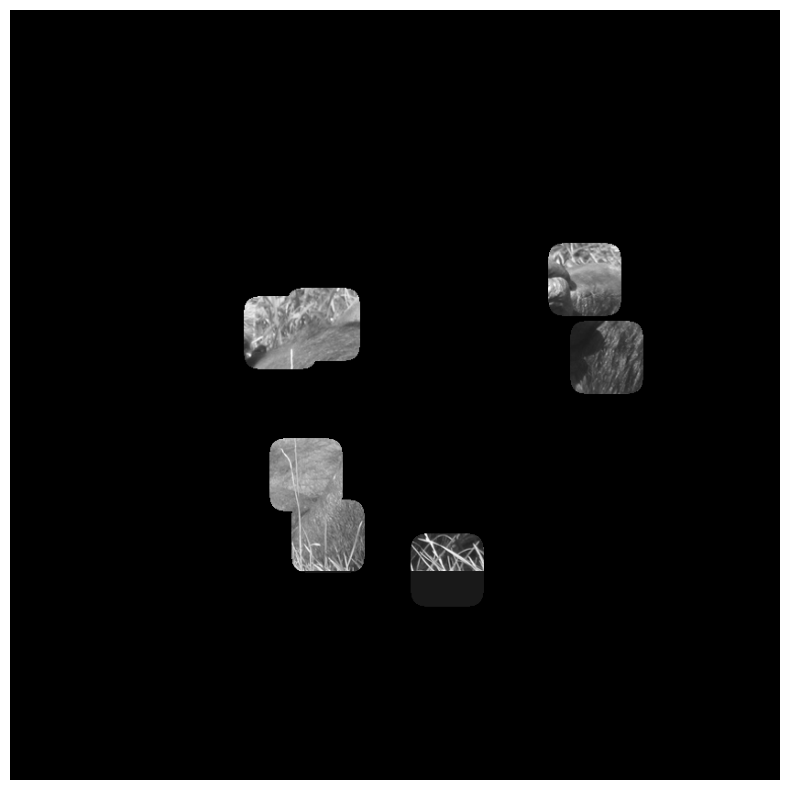

Have Generated Features for 300 Images.
First features for this species has dimensions of torch.Size([1, 3730500])
First image for rabbit with size (840, 840)


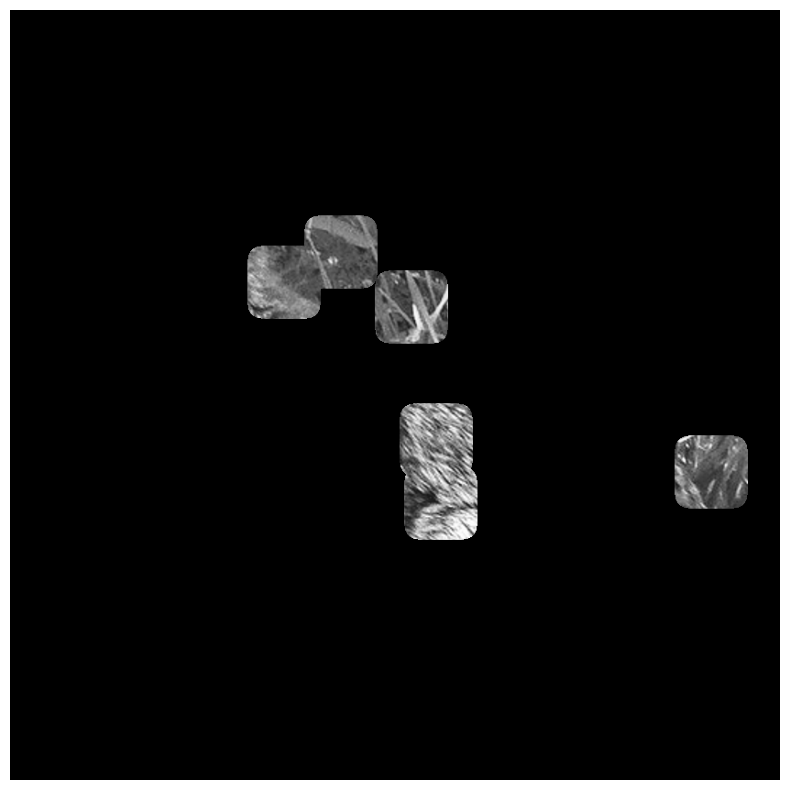

First features for this species has dimensions of torch.Size([1, 3730500])
First image for skunk with size (840, 840)


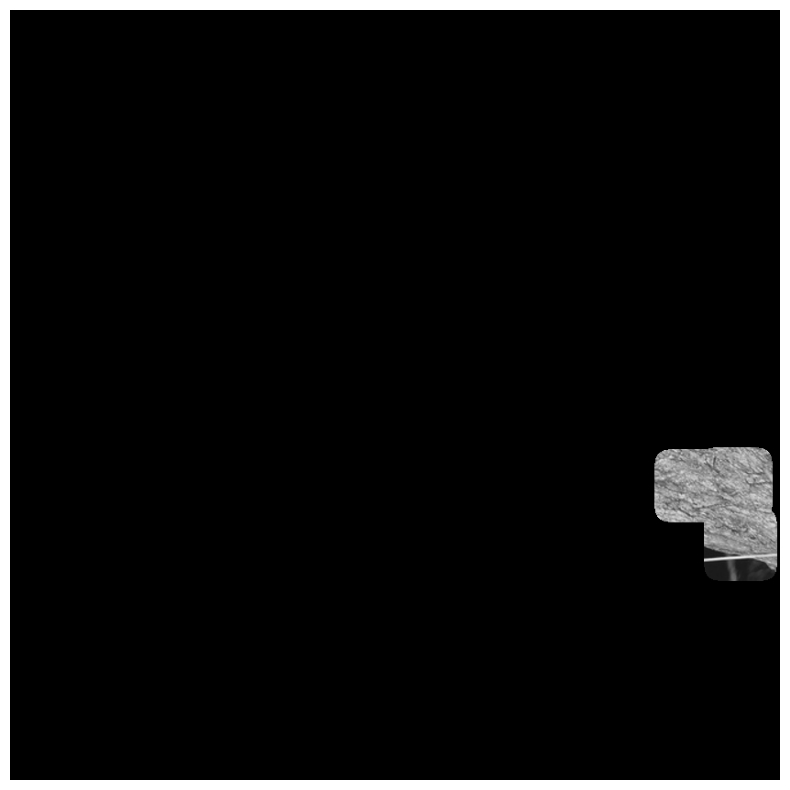

Have Generated Features for 400 Images.
First features for this species has dimensions of torch.Size([1, 3730500])
First image for mouse with size (840, 840)


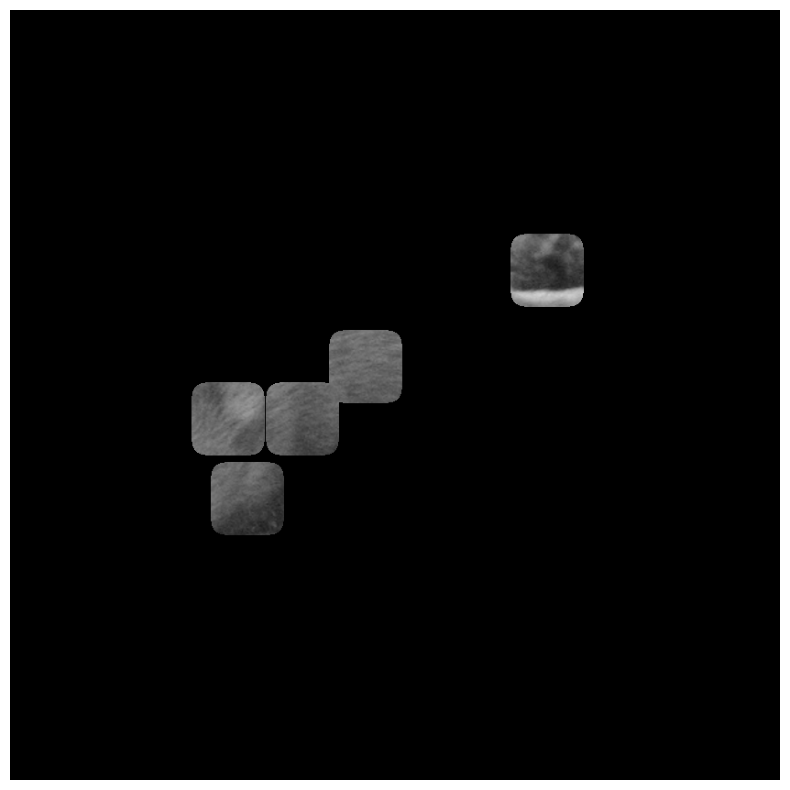

First features for this species has dimensions of torch.Size([1, 3730500])
First image for rat with size (840, 840)


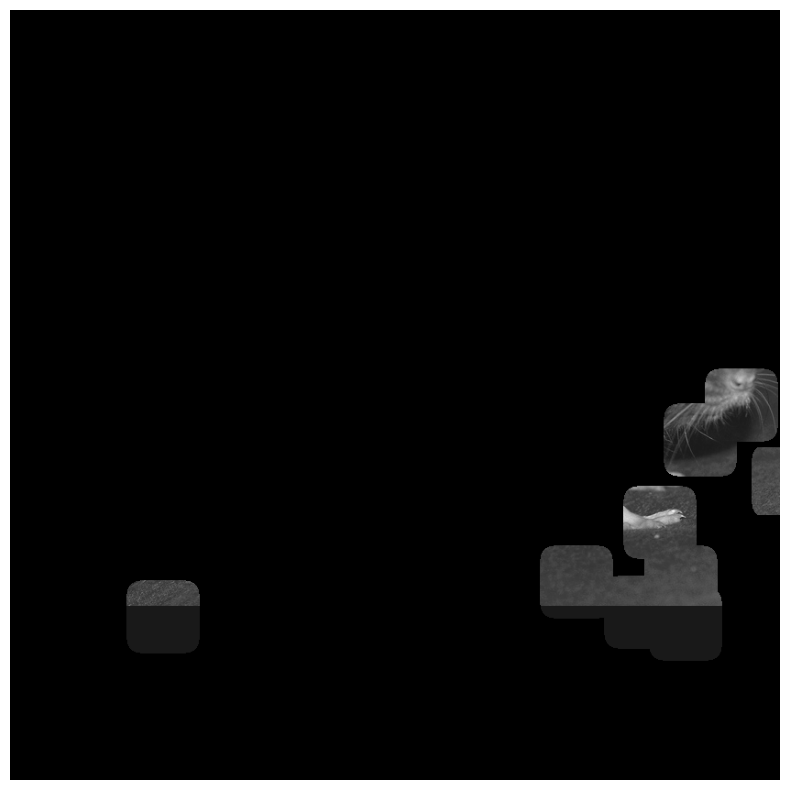

First features for this species has dimensions of torch.Size([1, 3730500])
First image for otter with size (840, 840)


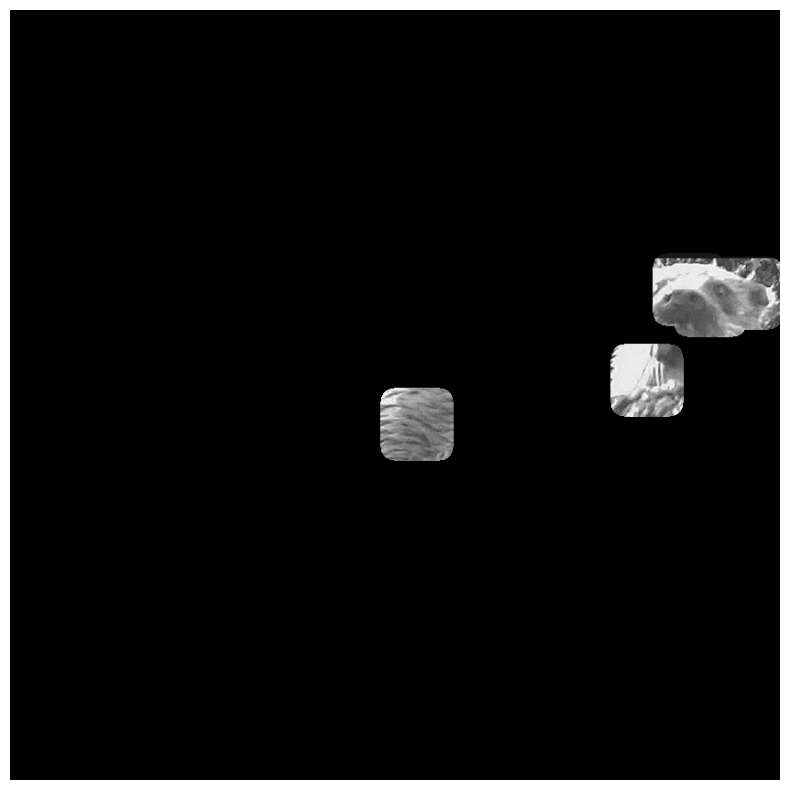

First features for this species has dimensions of torch.Size([1, 3730500])
First image for weasel with size (840, 840)


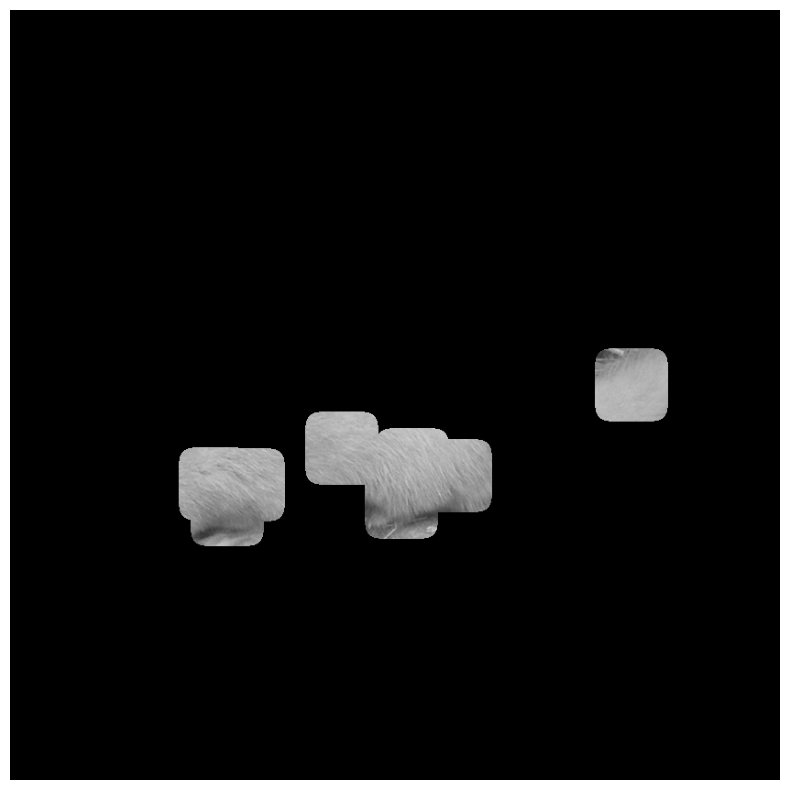

First features for this species has dimensions of torch.Size([1, 3730500])
First image for raccoon with size (840, 840)


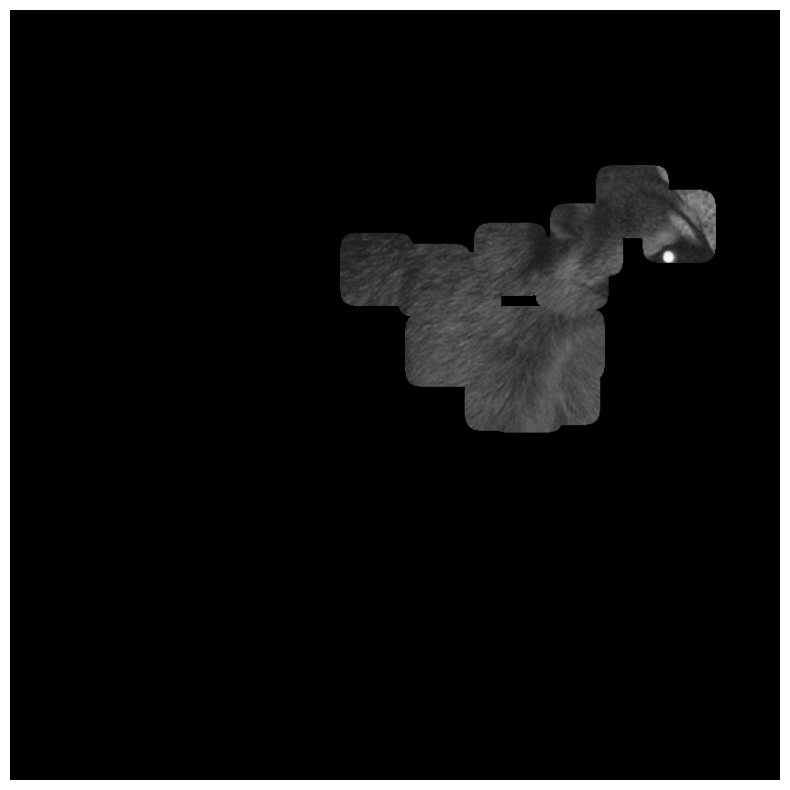

Have Generated Features for 500 Images.
First features for this species has dimensions of torch.Size([1, 3730500])
First image for rhino with size (840, 840)


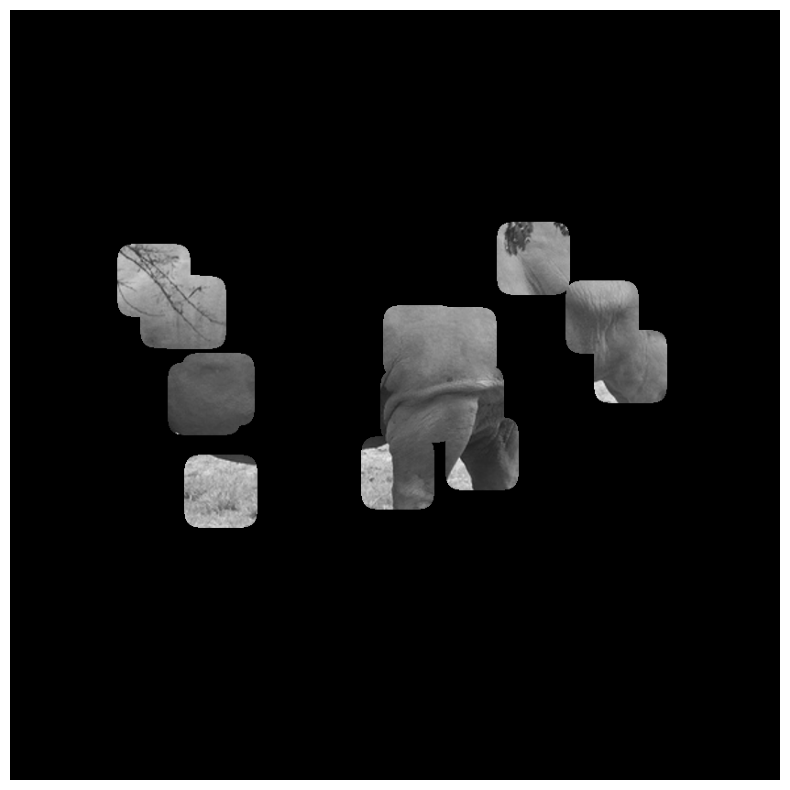

First features for this species has dimensions of torch.Size([1, 3730500])
First image for squirrel with size (840, 840)


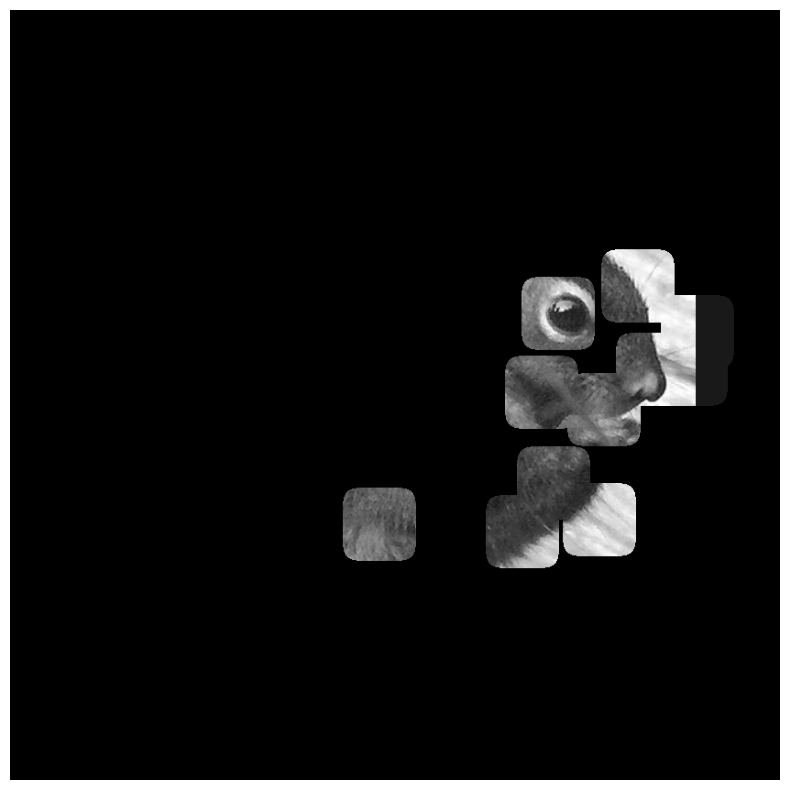

Have Generated Features for 600 Images.
First features for this species has dimensions of torch.Size([1, 3730500])
First image for pig with size (840, 840)


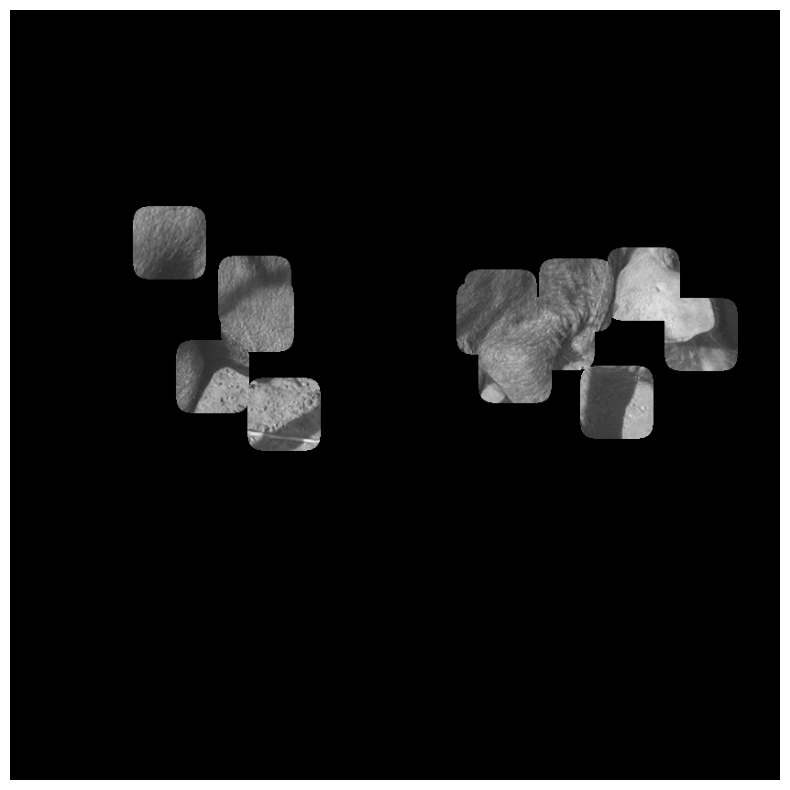

First features for this species has dimensions of torch.Size([1, 3730500])
First image for brown bear with size (840, 840)


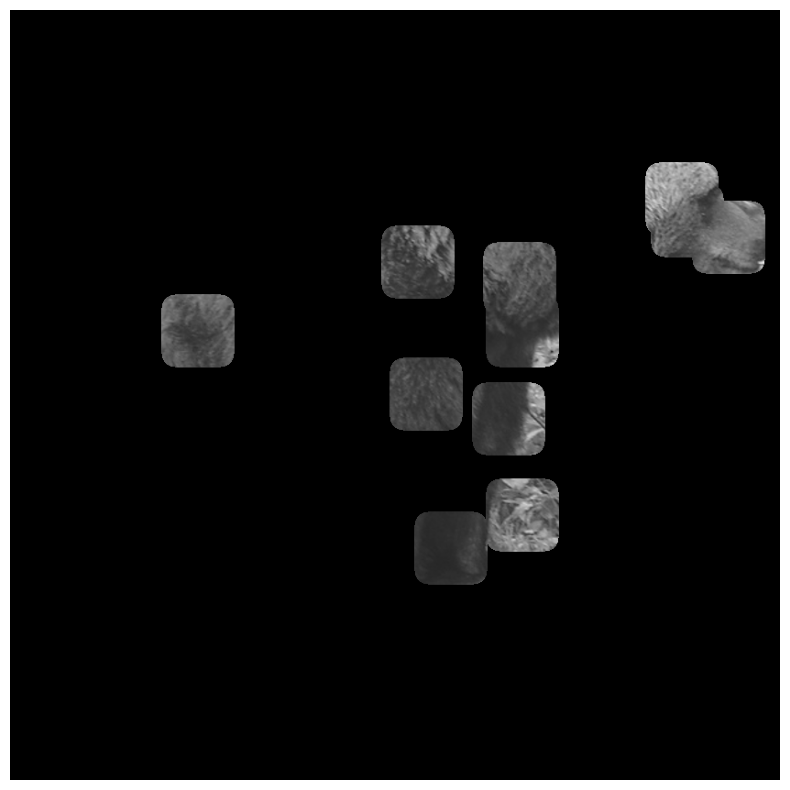

Have Generated Features for 700 Images.
First features for this species has dimensions of torch.Size([1, 3730500])
First image for panda with size (840, 840)


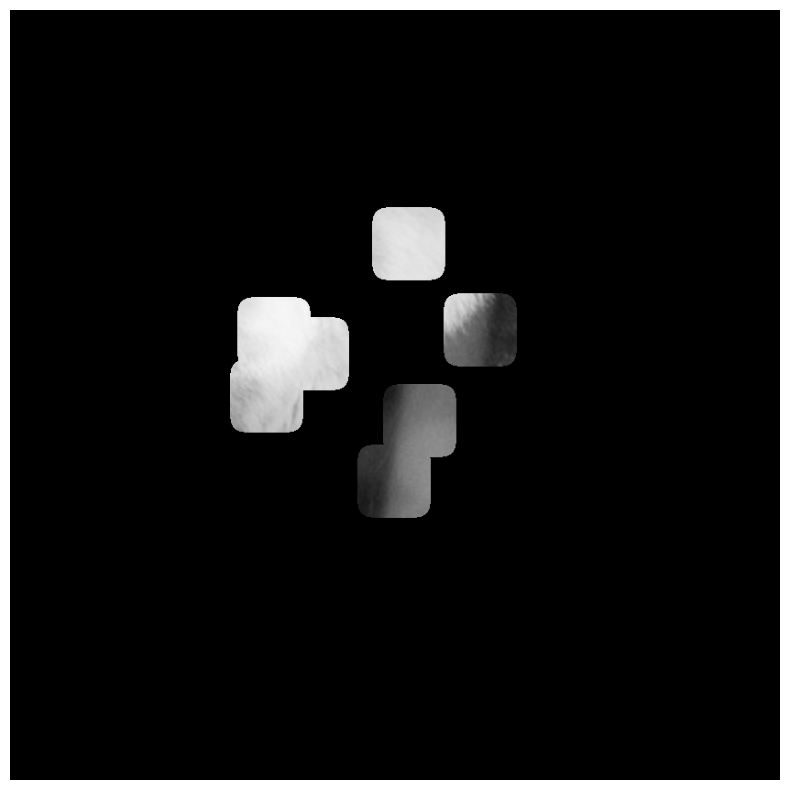

First features for this species has dimensions of torch.Size([1, 3730500])
First image for polar bear with size (840, 840)


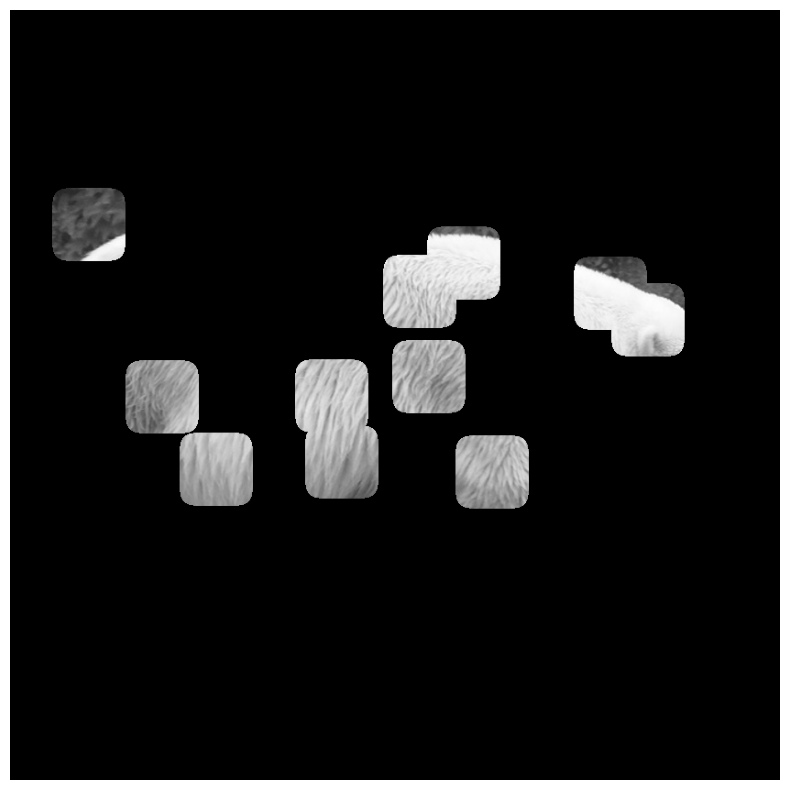

Have Generated Features for 800 Images.
First features for this species has dimensions of torch.Size([1, 3730500])
First image for bison with size (840, 840)


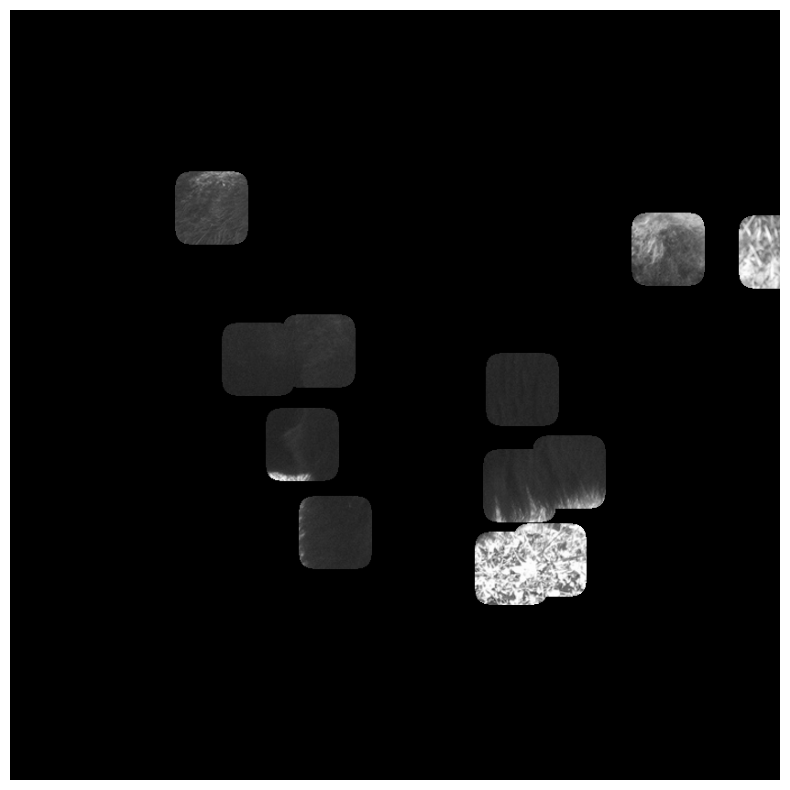

First features for this species has dimensions of torch.Size([1, 3730500])
First image for buffalo with size (840, 840)


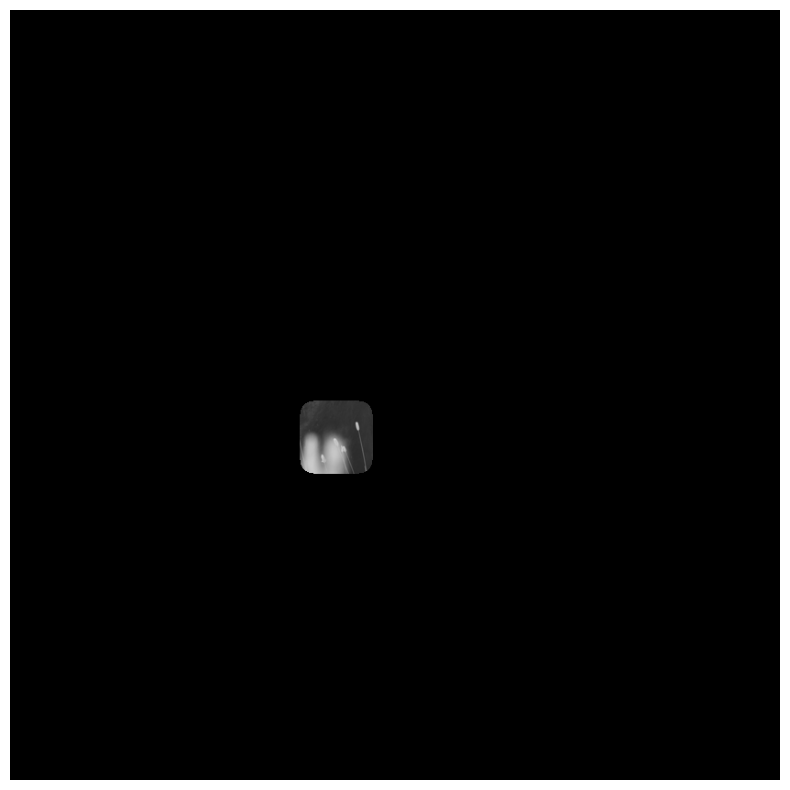

First features for this species has dimensions of torch.Size([1, 3730500])
First image for fox with size (840, 840)


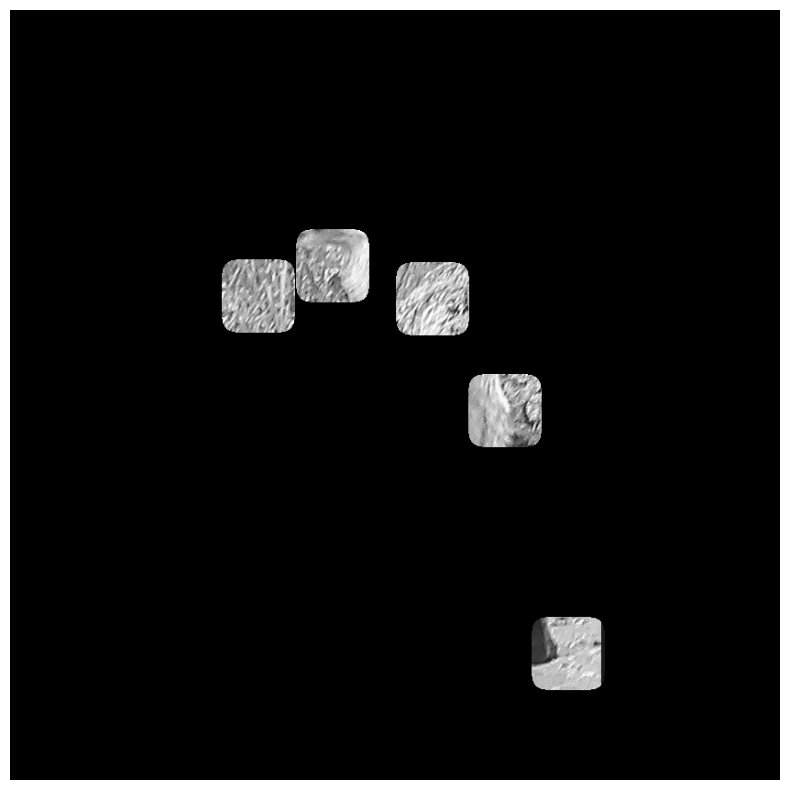

First features for this species has dimensions of torch.Size([1, 3730500])
First image for moose with size (840, 840)


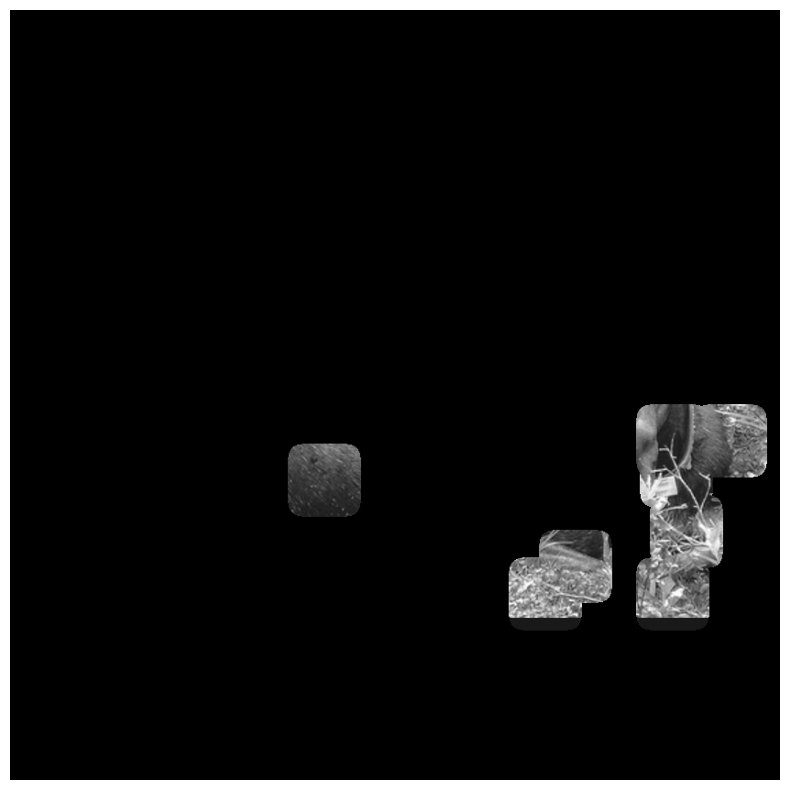

Have Generated Features for 900 Images.
First features for this species has dimensions of torch.Size([1, 3730500])
First image for noisy night monkey with size (840, 840)


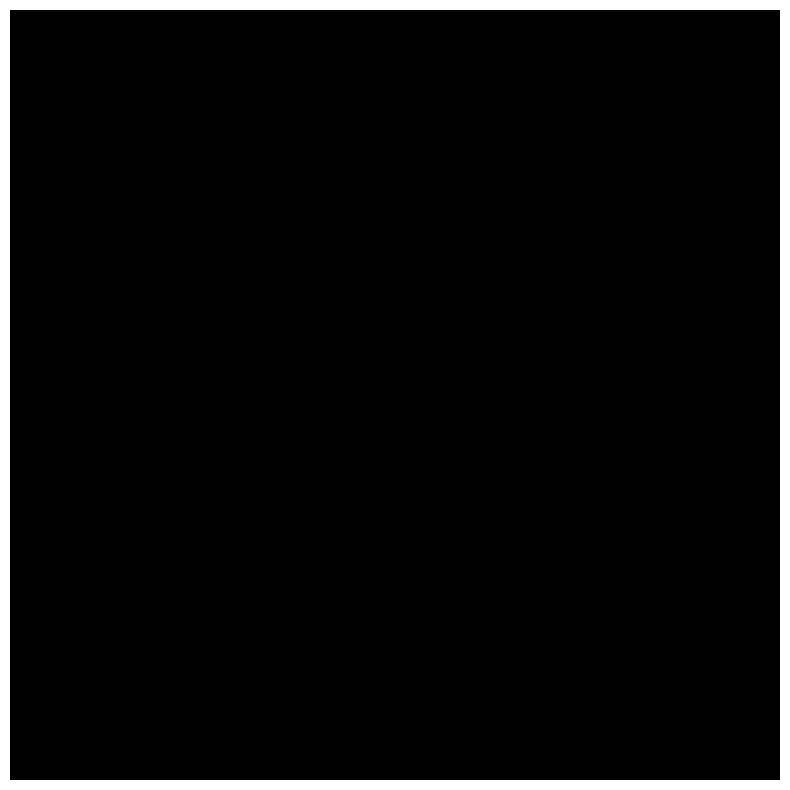

First features for this species has dimensions of torch.Size([1, 3730500])
First image for alouatta with size (840, 840)


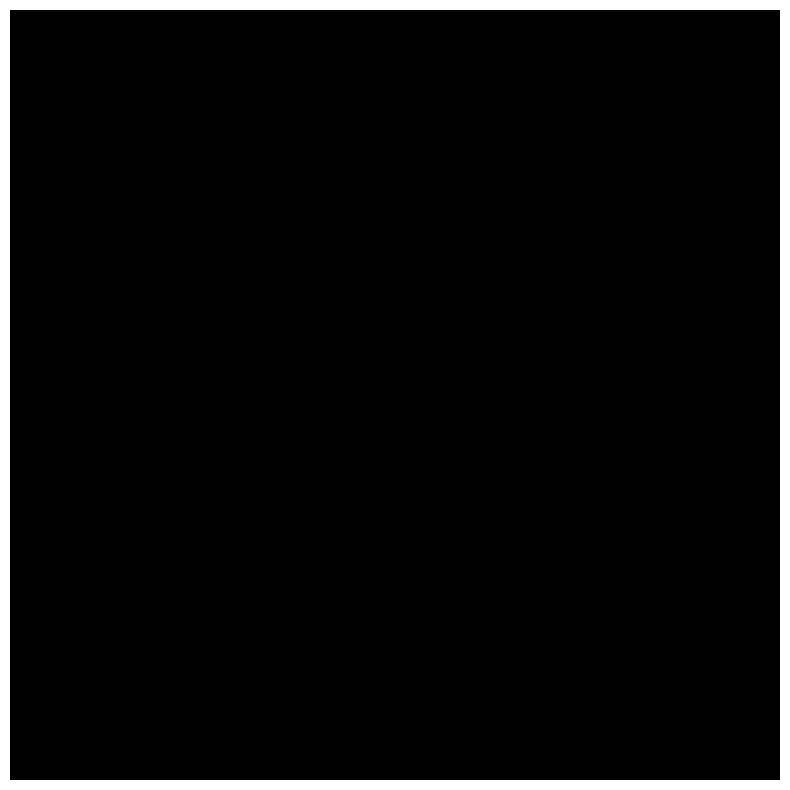

Have Generated Features for 1000 Images.
Have Generated Features for 1100 Images.
First features for this species has dimensions of torch.Size([1, 3730500])
First image for antelope with size (840, 840)


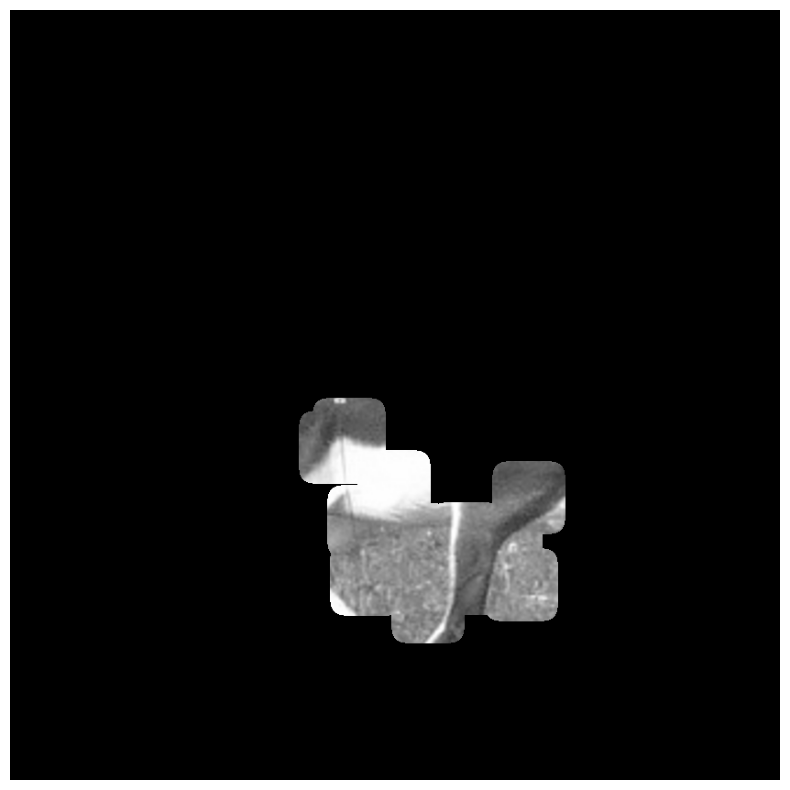

Have Generated Features for 1200 Images.
Have Generated Features for 1300 Images.
First features for this species has dimensions of torch.Size([1, 3730500])
First image for cow with size (840, 840)


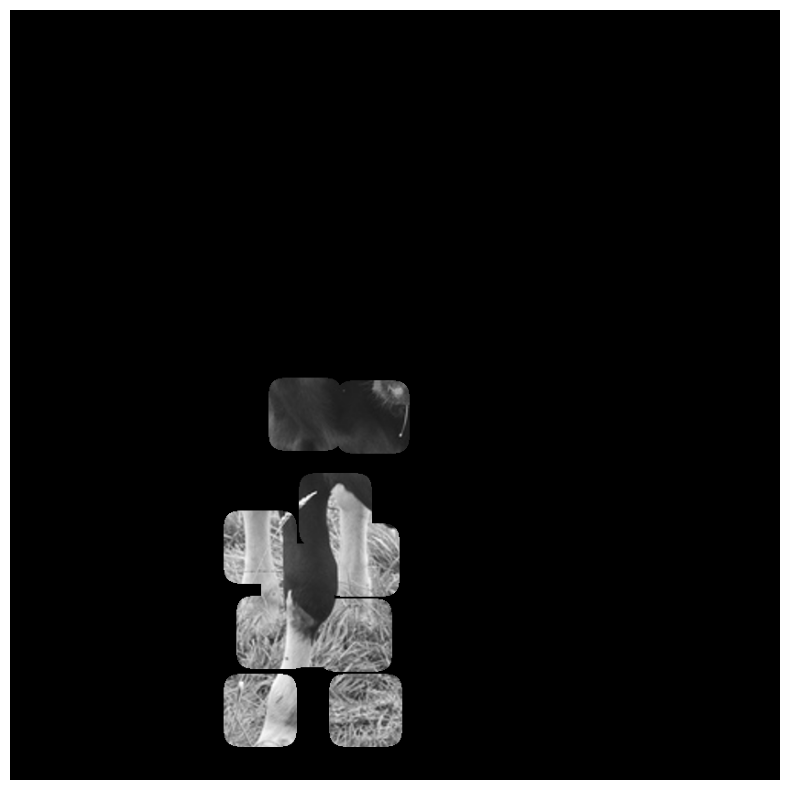

First features for this species has dimensions of torch.Size([1, 3730500])
First image for sheep with size (840, 840)


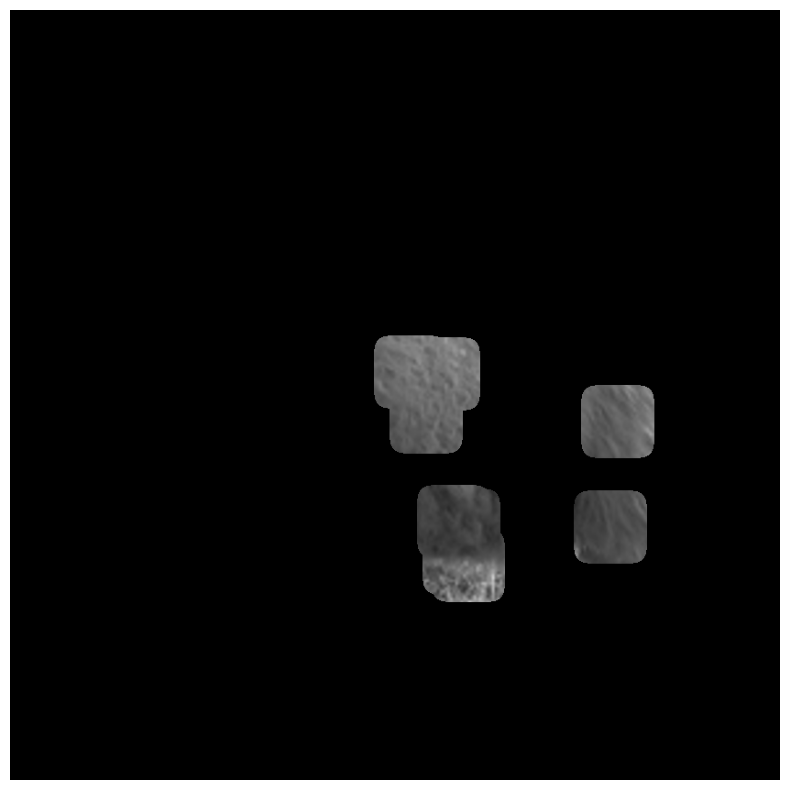

First features for this species has dimensions of torch.Size([1, 3730500])
First image for dog with size (840, 840)


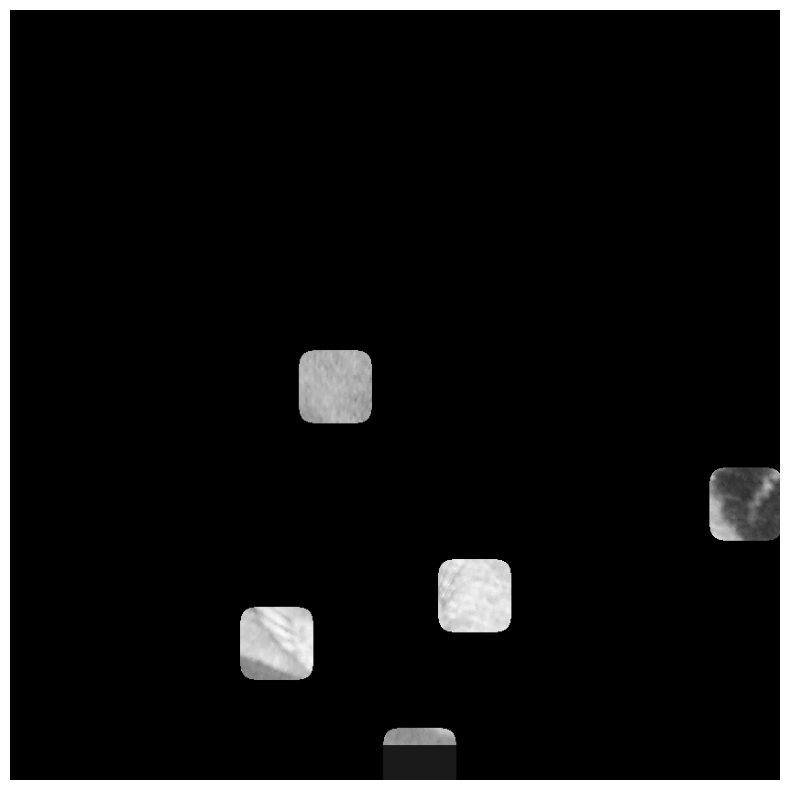

Have Generated Features for 1400 Images.
Have Generated Features for 1500 Images.
First features for this species has dimensions of torch.Size([1, 3730500])
First image for wolf with size (840, 840)


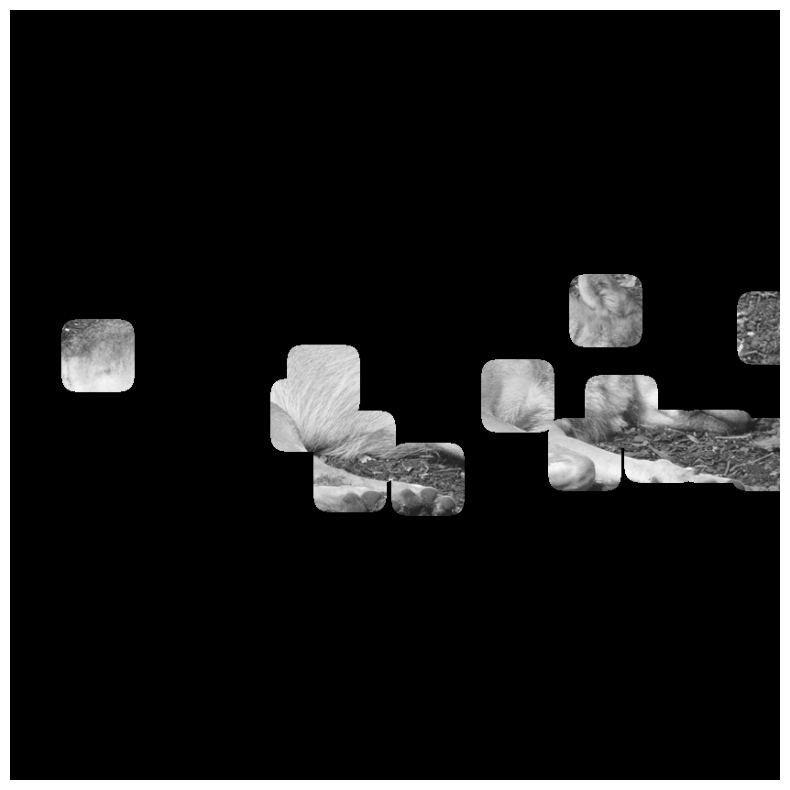

First features for this species has dimensions of torch.Size([1, 3730500])
First image for beaver with size (840, 840)


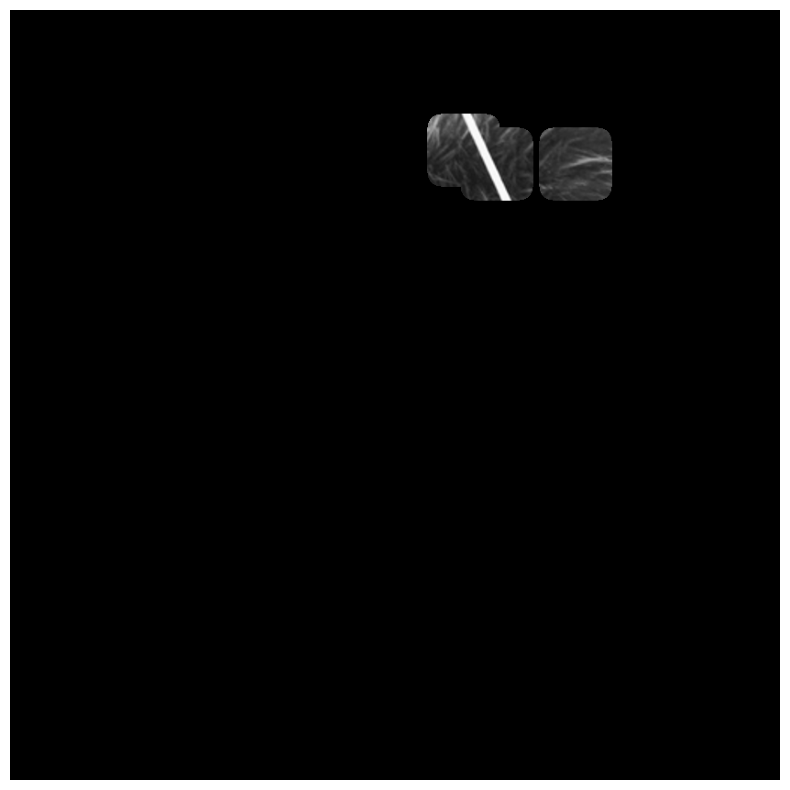

Have Generated Features for 1600 Images.
First features for this species has dimensions of torch.Size([1, 3730500])
First image for spider monkey with size (840, 840)


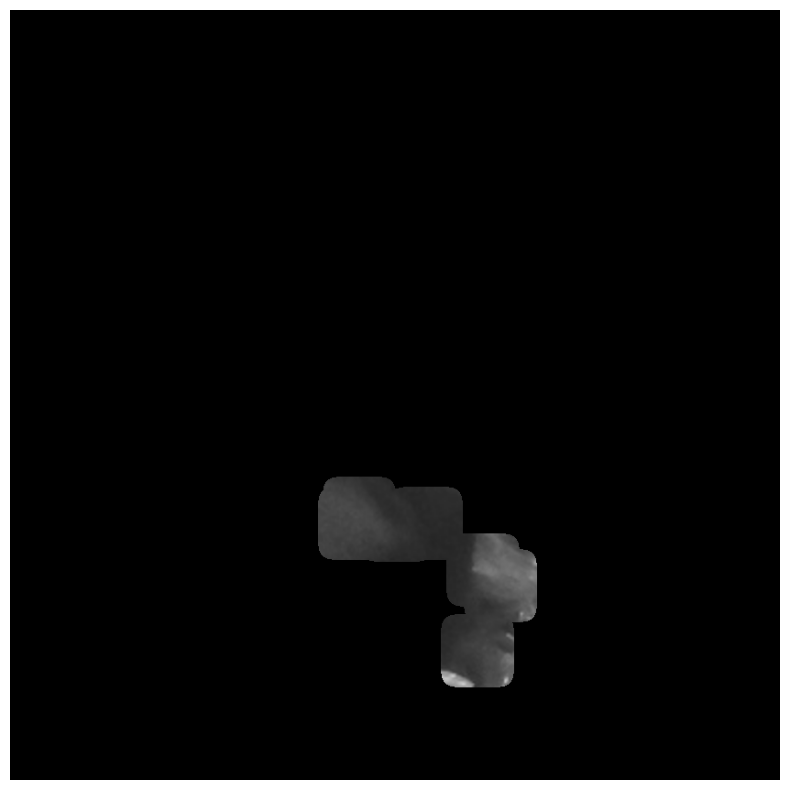

First features for this species has dimensions of torch.Size([1, 3730500])
First image for deer with size (840, 840)


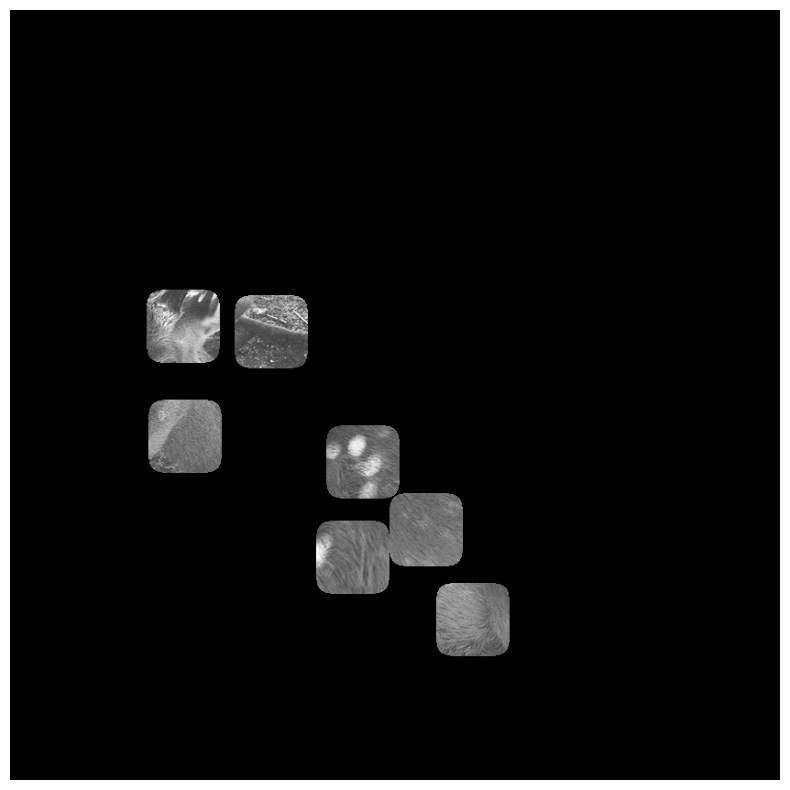

Have Generated Features for 1700 Images.
Have Generated Features for 1800 Images.
First features for this species has dimensions of torch.Size([1, 3730500])
First image for elephant with size (840, 840)


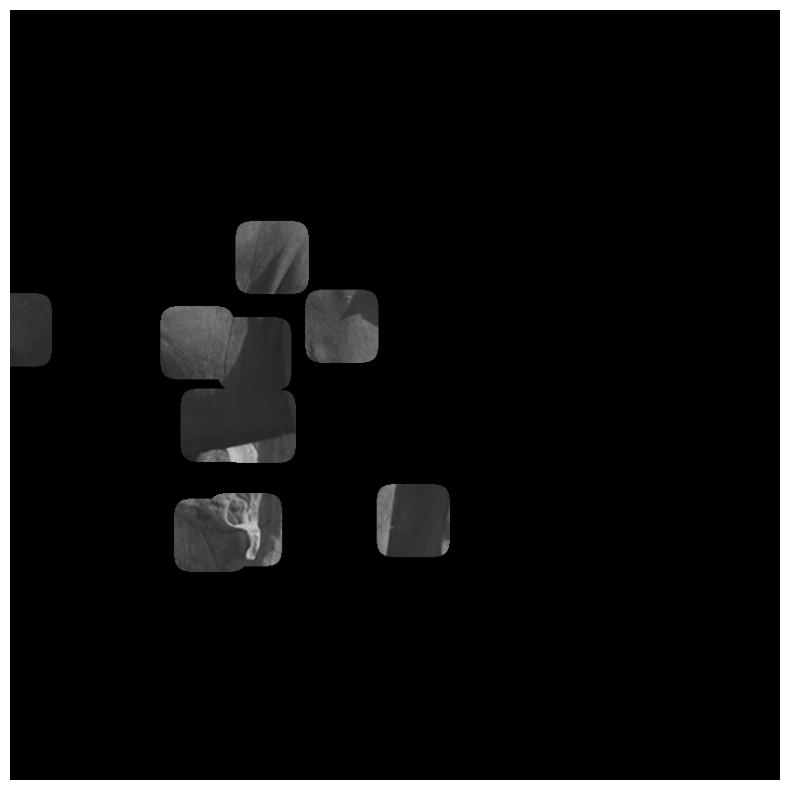

Have Generated Features for 1900 Images.
First features for this species has dimensions of torch.Size([1, 3730500])
First image for horse with size (840, 840)


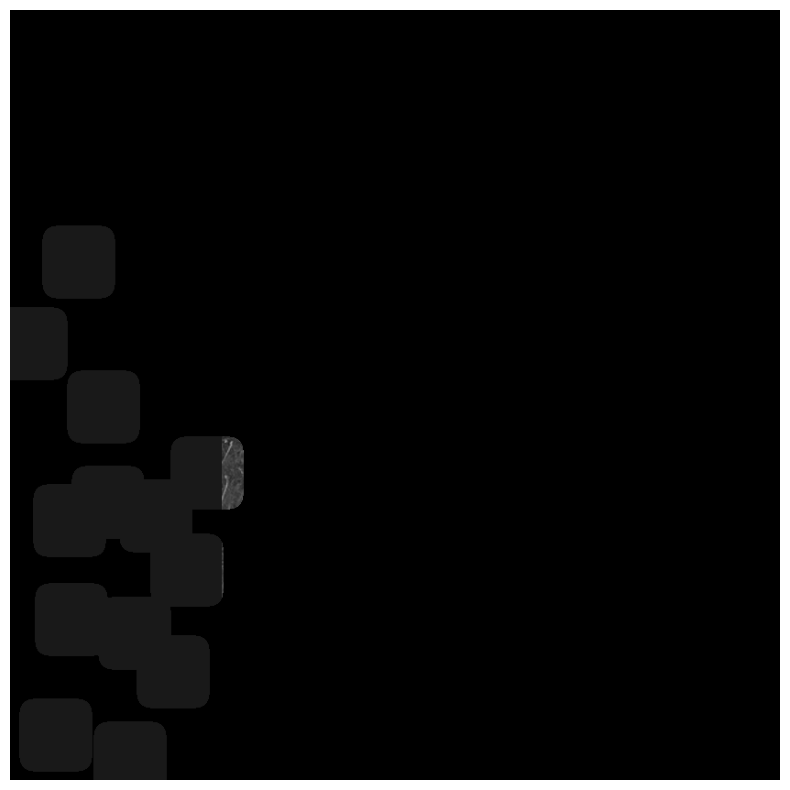

First features for this species has dimensions of torch.Size([1, 3730500])
First image for zebra with size (840, 840)


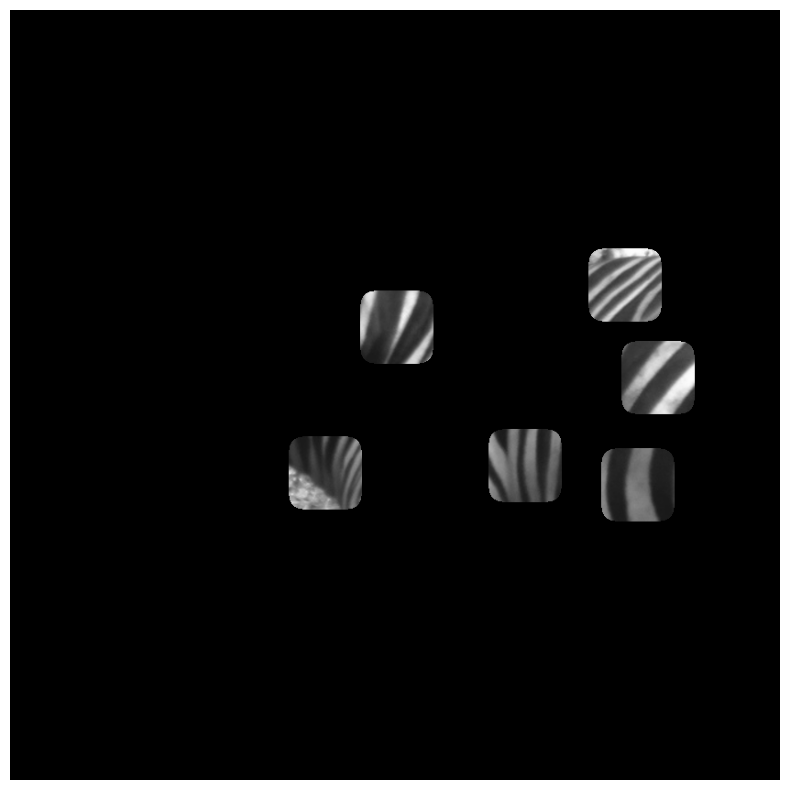

First features for this species has dimensions of torch.Size([1, 3730500])
First image for bobcat with size (840, 840)


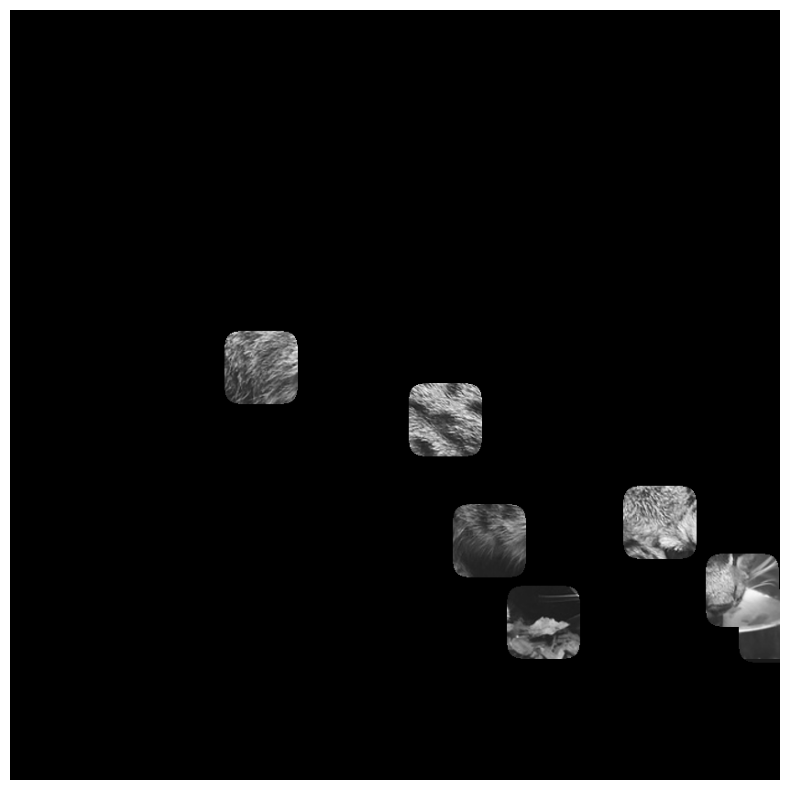

Have Generated Features for 2000 Images.
Have Generated Features for 2100 Images.
Have Generated Features for 2200 Images.
Have Generated Features for 2300 Images.
Have Generated Features for 2400 Images.
Have Generated Features for 2500 Images.
Have Generated Features for 2600 Images.
Have Generated Features for 2700 Images.
Have Generated Features for 2800 Images.
Have Generated Features for 2900 Images.
Have Generated Features for 3000 Images.
Have Generated Features for 3100 Images.
First features for this species has dimensions of torch.Size([1, 3730500])
First image for lion with size (840, 840)


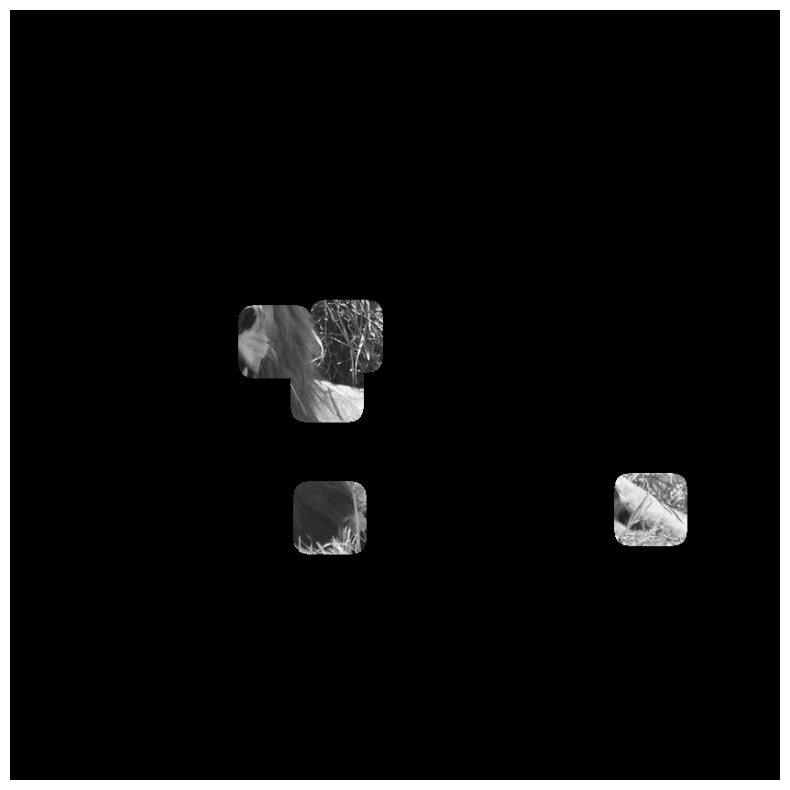

Have Generated Features for 3200 Images.
First features for this species has dimensions of torch.Size([1, 3730500])
First image for panther with size (840, 840)


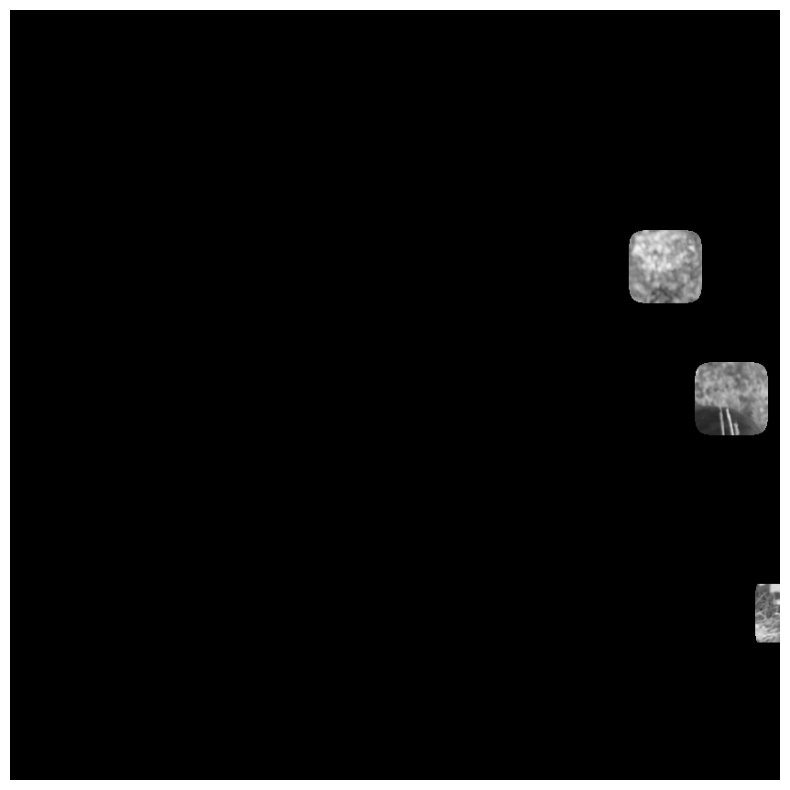

Have Generated Features for 3300 Images.
Have Generated Features for 3400 Images.
Have Generated Features for 3500 Images.
Have Generated Features for 3600 Images.
Have Generated Features for 3700 Images.
Have Generated Features for 3800 Images.
Have Generated Features for 3900 Images.
Have Generated Features for 4000 Images.
Have Generated Features for 4100 Images.
First features for this species has dimensions of torch.Size([1, 3730500])
First image for monkey with size (840, 840)


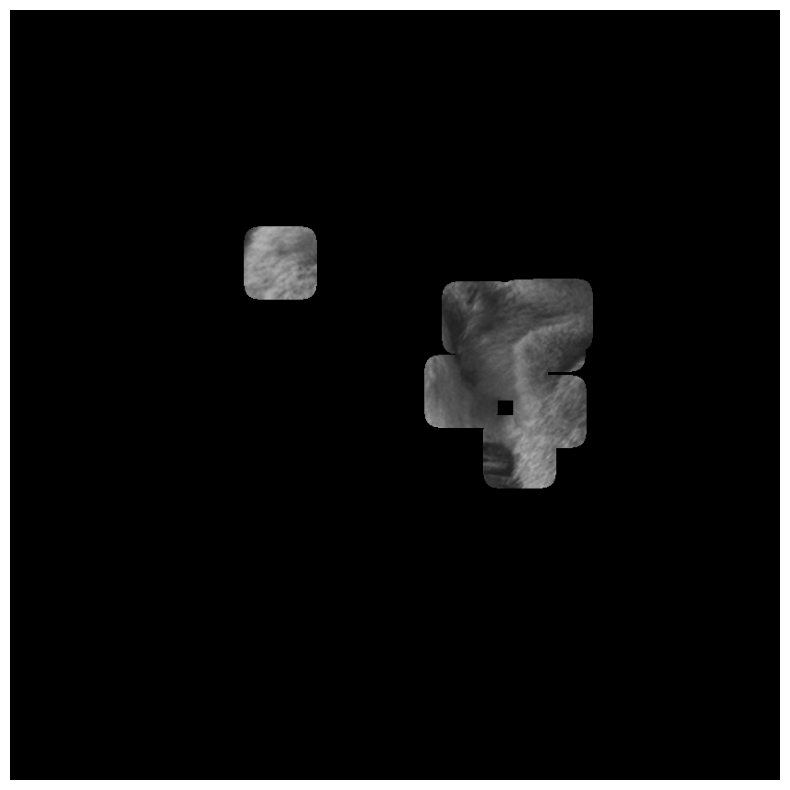

Have Generated Features for 4200 Images.
Have Generated Features for 4300 Images.
Have Generated Features for 4400 Images.
Have Generated Features for 4500 Images.
First features for this species has dimensions of torch.Size([1, 3730500])
First image for hamster with size (840, 840)


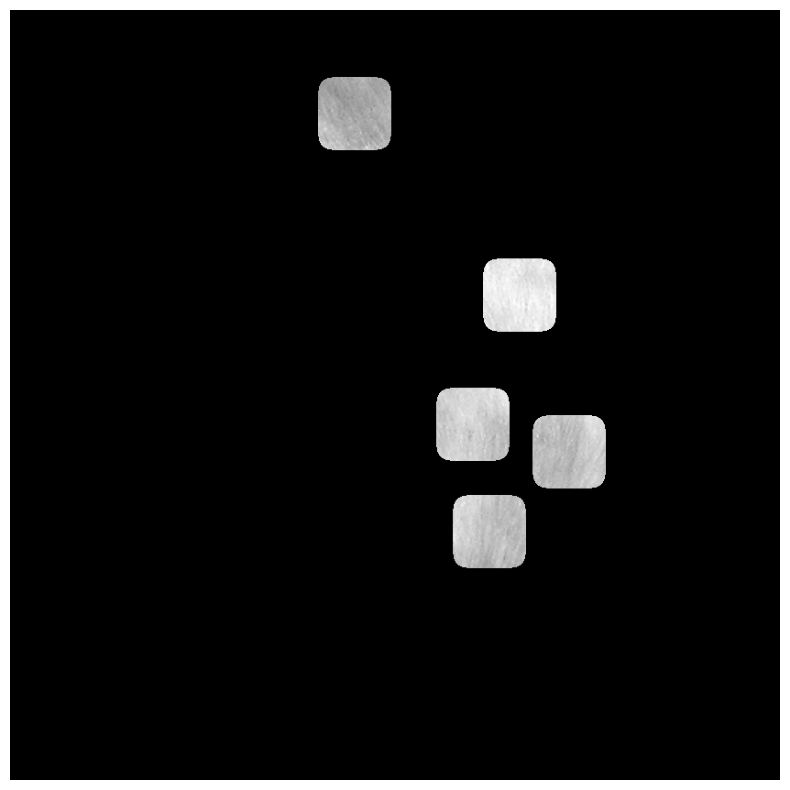

Have Generated Features for 4600 Images.
Have Generated Features for 4700 Images.
Have Generated Features for 4800 Images.
Have Generated Features for 4900 Images.
Have Generated Features for 5000 Images.
Have Generated Features for 5100 Images.
Have Generated Features for 5200 Images.
First features for this species has dimensions of torch.Size([1, 3730500])
First image for argali sheep with size (840, 840)


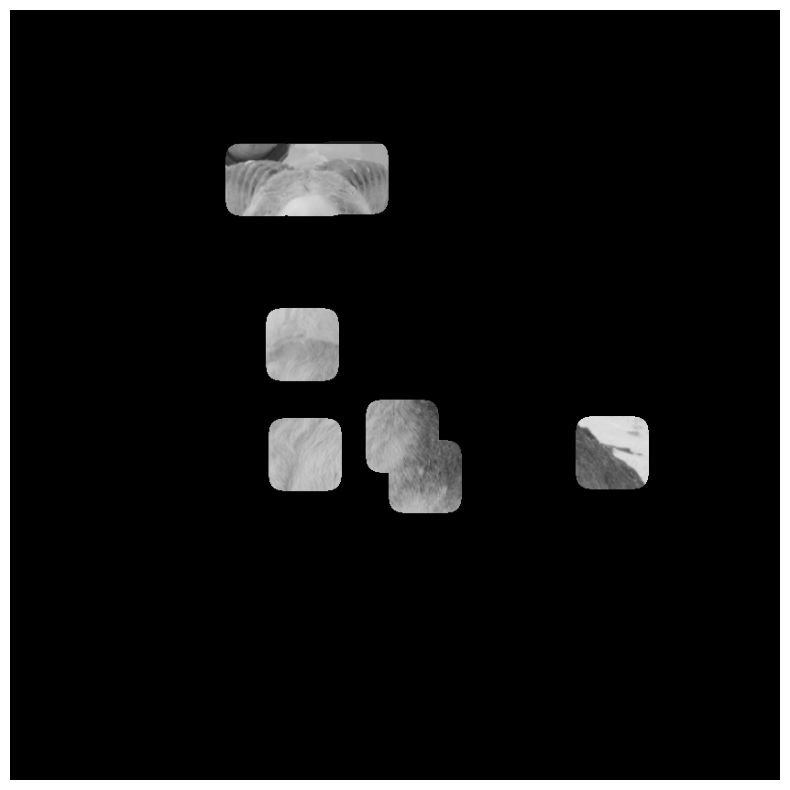

Have Generated Features for 5300 Images.
Have Generated Features for 5400 Images.
Have Generated Features for 5500 Images.
Have Generated Features for 5600 Images.
Have Generated Features for 5700 Images.
Have Generated Features for 5800 Images.
Have Generated Features for 5900 Images.
Have Generated Features for 6000 Images.
Have Generated Features for 6100 Images.
First features for this species has dimensions of torch.Size([1, 3730500])
First image for gorilla with size (840, 840)


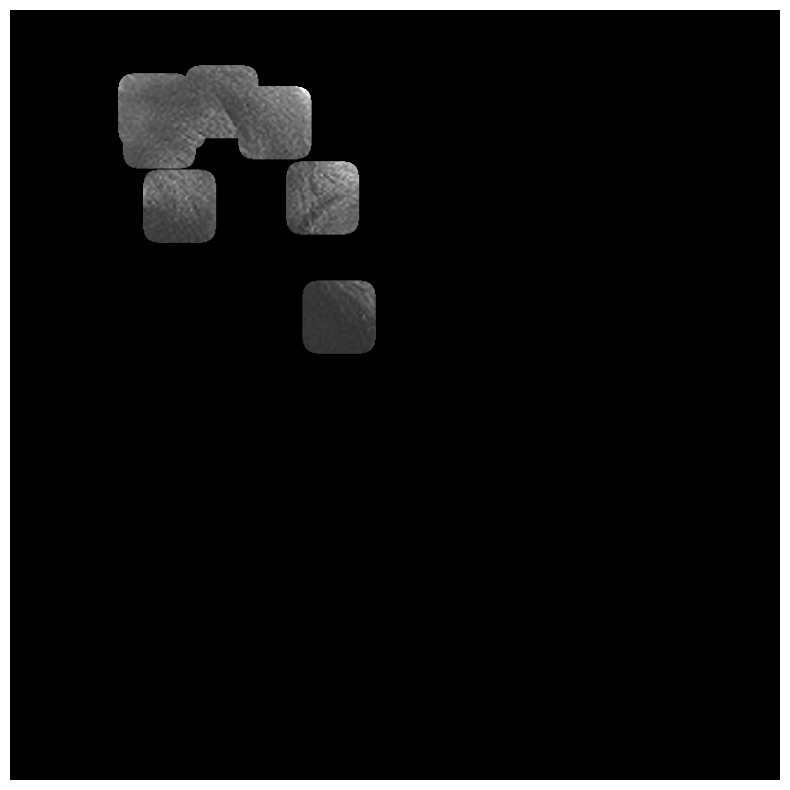

Have Generated Features for 6200 Images.
Have Generated Features for 6300 Images.
Have Generated Features for 6400 Images.
Have Generated Features for 6500 Images.
Have Generated Features for 6600 Images.
Have Generated Features for 6700 Images.
First features for this species has dimensions of torch.Size([1, 3730500])
First image for marmot with size (840, 840)


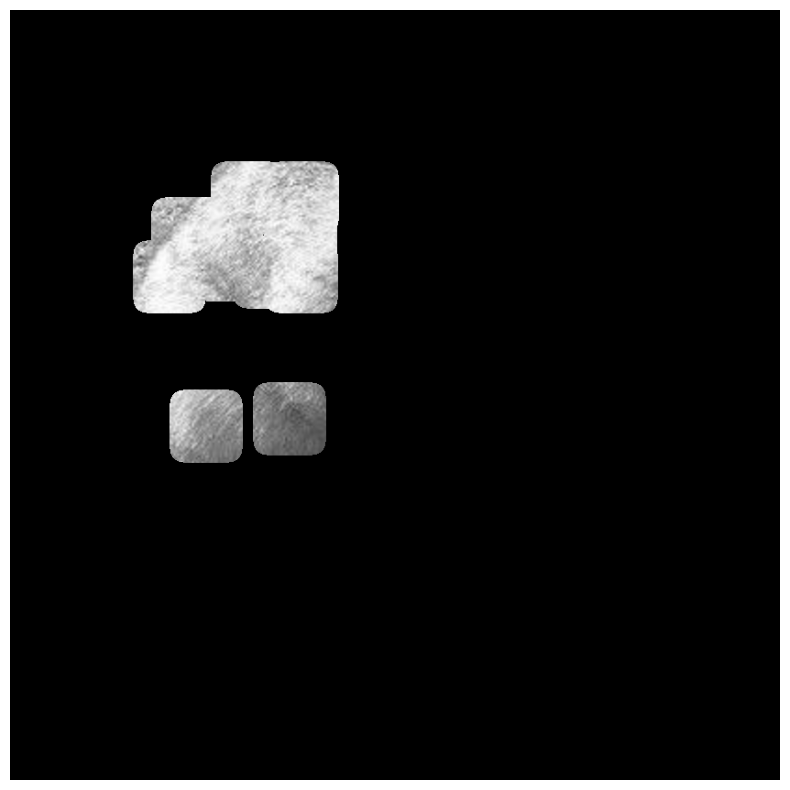

Have Generated Features for 6800 Images.
Have Generated Features for 6900 Images.
First features for this species has dimensions of torch.Size([1, 3730500])
First image for black bear with size (840, 840)


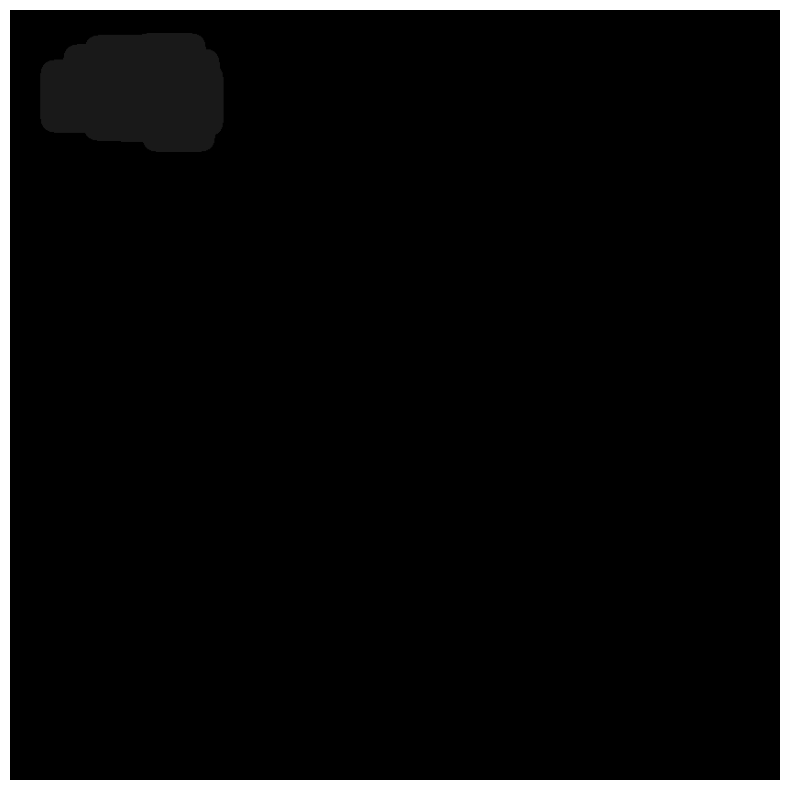

Have Generated Features for 7000 Images.
First features for this species has dimensions of torch.Size([1, 3730500])
First image for cheetah with size (840, 840)


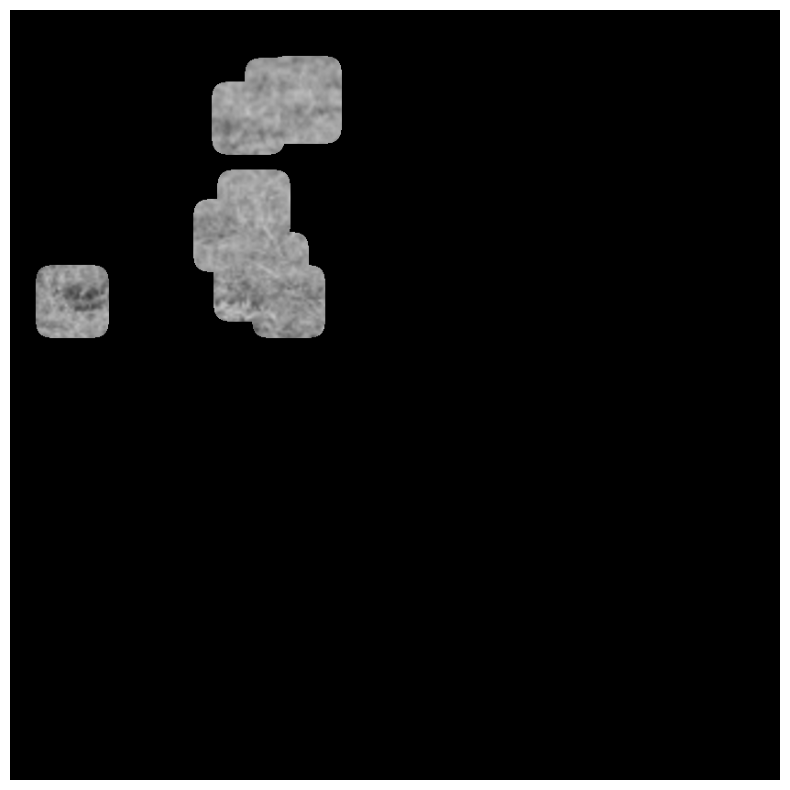

Have Generated Features for 7100 Images.
Have Generated Features for 7200 Images.
Have Generated Features for 7300 Images.
Have Generated Features for 7400 Images.
First features for this species has dimensions of torch.Size([1, 3730500])
First image for king cheetah with size (840, 840)


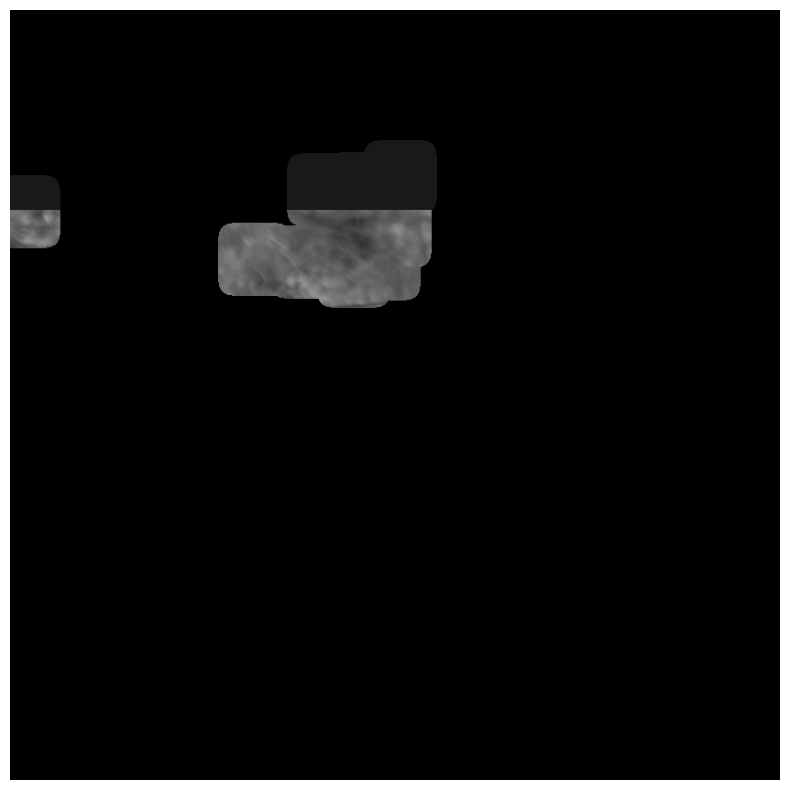

Have Generated Features for 7500 Images.
Have Generated Features for 7600 Images.
Have Generated Features for 7700 Images.
Have Generated Features for 7800 Images.
First features for this species has dimensions of torch.Size([1, 3730500])
First image for snow leopard with size (840, 840)


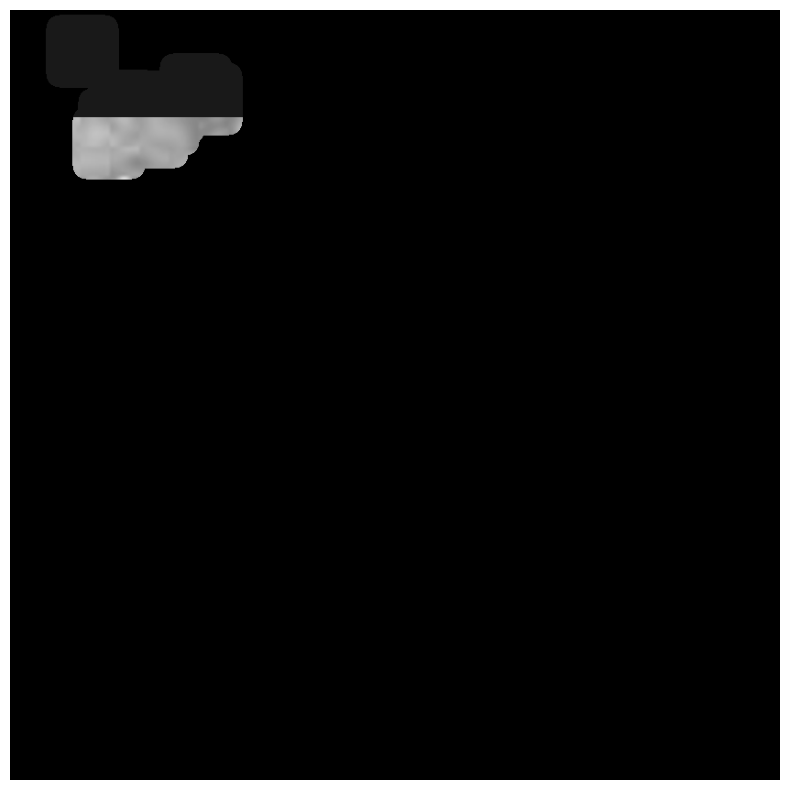

Have Generated Features for 7900 Images.
Have Generated Features for 8000 Images.
Have Generated Features for 8100 Images.
Have Generated Features for 8200 Images.
Have Generated Features for 8300 Images.
Have Generated Features for 8400 Images.
Have Generated Features for 8500 Images.
Have Generated Features for 8600 Images.
Have Generated Features for 8700 Images.
Have Generated Features for 8800 Images.
Have Generated Features for 8900 Images.
Have Generated Features for 9000 Images.
Have Generated Features for 9100 Images.
Have Generated Features for 9200 Images.
Have Generated Features for 9300 Images.
Have Generated Features for 9400 Images.
Have Generated Features for 9500 Images.
Have Generated Features for 9600 Images.
Have Generated Features for 9700 Images.
Have Generated Features for 9800 Images.
Have Generated Features for 9900 Images.
Have Generated Features for 10000 Images.
Feature extraction completed!


In [ ]:
dinov2_vitl14.to(device)

# Define paths
ap10k_folder = "/content/drive/MyDrive/ap10k/"
data_folder = os.path.join(ap10k_folder, "data")
annotations_path = os.path.join(ap10k_folder, "annotations", "annotations.json")

# Load AP10K annotations
with open(annotations_path, 'r') as file:
    annotations_data = json.load(file)

# Organize annotations by image_id
image_annotations = {ann["image_id"]: ann for ann in annotations_data["annotations"]}

# Assuming 'categories' is a list where each element is a dictionary containing 'id' and 'name'
categories = annotations_data['categories']  # Replace with your actual categories list or dictionary

# Create a mapping from category_id to category_name
category_mapping = {category['id']: category['name'] for category in categories}
print(category_mapping)

# Dictionary to store features by species
species_features = {}

# DINOv2 settings
patch_size = dinov2_vitl14.patch_size  # 14 for ViT-L/14
patch_h, patch_w = 224 // patch_size, 224 // patch_size
feat_dim_dinov2 = 1024  # ViT-L/14
cnt = 0
img_size = 840  # img size for resizing as DINOv2 + SD paper resizes to 840x840

# # Load Stable Diffusion pipeline (you might need to adjust the model name)
# from diffusers import StableDiffusionPipeline
# pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5").to(device)
# pipe.set_progress_bar_config(disable=True) # Suppress progress bar

# # Image transformation for DINOv2
# from torchvision import transforms
# transform1 = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

# Iterate through images in the data folder
with torch.no_grad():
    for file in os.listdir(data_folder):
        cnt += 1
        if cnt % 100 == 0:
            print(f"Have Generated Features for {cnt} Images.")
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            file_path = os.path.join(data_folder, file)
            image_id = int(os.path.splitext(file)[0])

            # Get species and bbox info from annotations
            annotation = image_annotations.get(image_id)
            if not annotation:
                continue  # Skip if no annotation
                print("Could Not Find Annotation!!")
            species_name = category_mapping[annotation["category_id"]]
            gt_bbox = annotation["bbox"]

            # Get keypoints
            keypoints = annotation.get("keypoints", [])
            num_keypoints = annotation.get("num_keypoints", 0)

            # Open image
            image = Image.open(file_path).convert("RGB")

            image_np = np.array(image)

            # Extract bounding box
            x_min, y_min, width, height = gt_bbox
            x_max, y_max = x_min + width, y_min + height
            bbox = [x_min, y_min, x_max, y_max]

            # Crop
            cropped_image = image_np[y_min:y_max, x_min:x_max]
            final_image = Image.fromarray(cropped_image)

            original_width, original_height = final_image.size

            # Compute new size while maintaining aspect ratio
            aspect_ratio = original_width / original_height

            if original_width > original_height:
                new_width = img_size
                new_height = int(img_size / aspect_ratio)
            else:
                new_height = img_size
                new_width = int(img_size * aspect_ratio)

            # Resize the image while preserving aspect ratio
            final_image = final_image.resize((new_width, new_height), Image.BICUBIC)
            resized_width, resized_height = final_image.size  # Get updated size after resizing

            # Calculate the padding needed on each side
            left_pad = (img_size - final_image.size[0]) // 2
            top_pad = (img_size - final_image.size[1]) // 2
            right_pad = img_size - final_image.size[0] - left_pad
            bottom_pad = img_size - final_image.size[1] - top_pad

            # Apply padding correctly
            image_with_padding = ImageOps.expand(final_image, (left_pad, top_pad, right_pad, bottom_pad), fill='black')
            final_image = image_with_padding

            final_image_np = np.array(final_image)

            # Create keypoint mask
            keypoint_mask = create_keypoint_mask(final_image_np.shape, keypoints, num_keypoints)

            # Convert image to grayscale
            grayscale_image = np.dot(final_image_np[...,:3], [0.2989, 0.5870, 0.1140])
            grayscale_image = grayscale_image / 255.0 * 0.9 + 0.1

            # Apply mask to grayscale image
            grayscale_image[~keypoint_mask] = 0
            grayscale_image = (grayscale_image * 255).astype(np.uint8)

            # Create masked image
            image_with_mask = final_image_np.copy()
            image_with_mask[~keypoint_mask] = 0
            image_with_mask[keypoint_mask] = np.expand_dims(grayscale_image, axis=-1)[keypoint_mask]
            final_image = Image.fromarray(image_with_mask)

            # Feature extraction with DINOv2
            img_t = transform1(final_image).to(device)
            features_dict = dinov2_vitl14.forward_features(img_t.unsqueeze(0))
            dinov2_features = features_dict['x_norm_patchtokens'].flatten(1) # Flatten to [1, num_patches * feature_dim]

            # Feature extraction with Stable Diffusion
            with torch.autograd.no_grad():
                image_input = transform1(final_image).unsqueeze(0).to(device)
                latent = pipe.vae.encode(image_input).latent_dist.sample()
                latent = latent * 0.18215
                sd_features = latent.flatten(1)

            # Normalize DINOv2 and Stable Diffusion features
            dinov2_features = dinov2_features / dinov2_features.norm(dim=-1, keepdim=True)
            sd_features = sd_features / sd_features.norm(dim=-1, keepdim=True)

            # Combine features
            combined_features = torch.cat([dinov2_features, sd_features], dim=-1).cpu() # Move to CPU

            # Store features in species dictionary
            if species_name not in species_features:
                print(f"First features for this species has dimensions of {combined_features.size()}")
                species_features[species_name] = []
                print(f"First image for {species_name} with size {final_image.size}")
                plt.figure(figsize=(10, 10))
                plt.imshow(final_image)
                plt.axis('off')
                plt.show()
            species_features[species_name].append(combined_features.cpu()) # Ensure the appended tensor is on CPU

# Convert lists to tensors
for species in species_features:
    species_features[species] = torch.cat(species_features[species], dim=0)

print("Feature extraction completed!")


## Analysis

### Quantitative Species Similarity

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import torch

# Dictionary to store the average feature vector for each species
species_avg_vectors = {}

for species_name, species_feature in species_features.items():
    num_images = species_feature.shape[0]

    # Flattening the output of each image into a vector
    species_feature = species_feature.reshape(num_images, -1)
    avg_vector = species_feature.mean(axis=0)

    # Store the average feature vector
    species_avg_vectors[species_name] = avg_vector

# Get the average feature vector for antelopes
antelope_vector = species_avg_vectors.get("antelope")
if antelope_vector is None:
    raise ValueError("No feature vector found for 'antelope'. Ensure it's in the species list.")

# Compute cosine similarity of all species with respect to antelopes
cosine_similarities = []
for species_name, avg_vector in species_avg_vectors.items():
    similarity = cosine_similarity(avg_vector.cpu().reshape(1, -1), antelope_vector.cpu().reshape(1, -1))[0][0]
    cosine_similarities.append((species_name, similarity))

# Sort species by descending cosine similarity
cosine_similarities.sort(key=lambda x: x[1], reverse=True)

# Print results
for species_name, similarity in cosine_similarities:
    print(f"{species_name}: {similarity:.4f}")

antelope: 1.0000
pig: 0.9817
deer: 0.9815
cow: 0.9802
squirrel: 0.9789
fox: 0.9789
polar bear: 0.9775
raccoon: 0.9762
bobcat: 0.9759
dog: 0.9753
elephant: 0.9740
rabbit: 0.9739
spider monkey: 0.9739
rat: 0.9730
wolf: 0.9724
bison: 0.9723
sheep: 0.9720
weasel: 0.9716
tiger: 0.9711
skunk: 0.9706
hippo: 0.9703
giraffe: 0.9689
otter: 0.9687
mouse: 0.9684
rhino: 0.9672
leopard: 0.9660
chimpanzee: 0.9651
panda: 0.9648
cat: 0.9647
brown bear: 0.9643
monkey: 0.9626
beaver: 0.9596
moose: 0.9585
buffalo: 0.9574
horse: 0.9562
lion: 0.9553
noisy night monkey: 0.9550
hamster: 0.9511
alouatta: 0.9504
zebra: 0.9483
marmot: 0.9405
argali sheep: 0.9400
panther: 0.9257
black bear: 0.9206
snow leopard: 0.9182
cheetah: 0.9128
jaguar: 0.9078
king cheetah: 0.9066
gorilla: 0.8711


In [ ]:
import numpy as np
import torch
from sklearn.neighbors import NearestNeighbors
from collections import Counter

# Flatten and collect all species feature vectors (excluding antelope)
all_features = []
labels = []

for species_name, species_feature in species_features.items():
    if species_name == "antelope":
        continue  # Skip antelope embeddings

    num_images = species_feature.shape[0]
    species_feature = species_feature.reshape(num_images, -1).cpu().numpy()  # Convert to CPU NumPy
    all_features.append(species_feature)
    labels.extend([species_name] * num_images)  # Track species labels

# Stack all non-antelope feature vectors into a single matrix
all_features = np.vstack(all_features)

# Get antelope features (to query k-NN)
if "antelope" not in species_features:
    raise ValueError("No feature vector found for 'antelope'. Ensure it's in the species list.")

antelope_features = species_features["antelope"].reshape(-1, all_features.shape[1]).cpu().numpy()

# Train k-NN only on non-antelope species
knn = NearestNeighbors(n_neighbors=10, metric="cosine")  # Adjust k as needed
knn.fit(all_features)

# Find the k nearest neighbors for antelope images (excluding other antelopes)
distances, indices = knn.kneighbors(antelope_features)

# Count occurrences of nearest species
nearest_species = Counter([labels[i] for i in indices.flatten()])

# Print species ranked by frequency in nearest neighbors
print("\nMost Similar Species to Antelopes (Excluding Other Antelopes):")
for species_name, count in nearest_species.most_common():
    print(f"{species_name}: {count}")


Most Similar Species to Antelopes (Excluding Other Antelopes):
squirrel: 11
rabbit: 8
mouse: 6
moose: 6
skunk: 6
dog: 5
raccoon: 5
sheep: 5
otter: 4
deer: 4
fox: 4
rhino: 3
polar bear: 3
rat: 3
pig: 3
cow: 3
cat: 3
hippo: 2
hamster: 2
wolf: 2
bison: 2
giraffe: 2
weasel: 2
panther: 2
horse: 1
chimpanzee: 1
leopard: 1
buffalo: 1
monkey: 1
beaver: 1
elephant: 1
bobcat: 1
tiger: 1
panda: 1
jaguar: 1
brown bear: 1
cheetah: 1
snow leopard: 1


In [ ]:
import numpy as np
import torch
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from collections import Counter

# Flatten and collect all species feature vectors (excluding antelope)
all_features = []
labels = []

for species_name, species_feature in species_features.items():
    if species_name == "antelope":
        continue  # Skip antelope embeddings

    num_images = species_feature.shape[0]
    species_feature = species_feature.reshape(num_images, -1).cpu().numpy()  # Convert to CPU NumPy
    all_features.append(species_feature)
    labels.extend([species_name] * num_images)  # Track species labels

# Stack all non-antelope feature vectors into a single matrix
all_features = np.vstack(all_features)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=10)  # Adjust n_components based on your dataset
all_features_pca = pca.fit_transform(all_features)

# Get antelope features and transform them using the same PCA model
if "antelope" not in species_features:
    raise ValueError("No feature vector found for 'antelope'. Ensure it's in the species list.")

antelope_features = species_features["antelope"].reshape(-1, all_features.shape[1]).cpu().numpy()
antelope_features_pca = pca.transform(antelope_features)  # Apply PCA transformation

# Train k-NN only on PCA-transformed non-antelope species
knn = NearestNeighbors(n_neighbors=10, metric="cosine")  # Adjust k as needed
knn.fit(all_features_pca)

# Find the k nearest neighbors for antelope images (excluding other antelopes)
distances, indices = knn.kneighbors(antelope_features_pca)

# Count occurrences of nearest species
nearest_species = Counter([labels[i] for i in indices.flatten()])

# Print species ranked by frequency in nearest neighbors
print("\nMost Similar Species to Antelopes (Using PCA & Excluding Other Antelopes):")
for species_name, count in nearest_species.most_common():
    print(f"{species_name}: {count}")


Most Similar Species to Antelopes (Using PCA & Excluding Other Antelopes):
squirrel: 15
elephant: 8
skunk: 8
dog: 7
deer: 6
weasel: 5
mouse: 4
raccoon: 4
pig: 4
polar bear: 4
giraffe: 3
sheep: 3
cow: 3
bison: 3
rat: 3
lion: 2
rabbit: 2
panda: 2
bobcat: 2
horse: 2
alouatta: 2
panther: 2
hippo: 2
cat: 1
tiger: 1
wolf: 1
chimpanzee: 1
leopard: 1
buffalo: 1
fox: 1
moose: 1
monkey: 1
otter: 1
brown bear: 1
argali sheep: 1
snow leopard: 1
jaguar: 1


### PCA Visualization

##### Antelopes Images with DINOv2 PCA

In [ ]:
# 2nd PCA for only foreground patches
pca.fit(pre_pca_features[pca_features_fg].cpu())
pca_features_left = pca.transform(pre_pca_features[pca_features_fg].cpu())

for i in range(3):
    # min_max scaling
    pca_features_left[:, i] = (pca_features_left[:, i] - pca_features_left[:, i].min()) / (pca_features_left[:, i].max() - pca_features_left[:, i].min())

pca_features_rgb = pca_features.copy()
# for black background
pca_features_rgb[pca_features_bg] = 0
# new scaled foreground features
pca_features_rgb[pca_features_fg] = pca_features_left

# Construct the path to the subfolder
subfolder_path = os.path.join(folder_path, pca_animal)

# Get a list of image files in the subfolder
image_files = [f for f in os.listdir(subfolder_path)]

# reshaping to numpy image format
pca_features_rgb = pca_features_rgb.reshape(len(image_files), patch_h, patch_w, 3)
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(pca_features_rgb[i])

plt.show()

##### Un-altered Antelope Images

In [ ]:
# Construct the path to the subfolder
subfolder_path = os.path.join(folder_path, pca_animal)

# Get a list of image files in the subfolder
image_files = [f for f in os.listdir(subfolder_path)]

# Loop through the first 4 images
for i, img_file in enumerate(image_files[:4]):
  img_path = os.path.join(subfolder_path, img_file)
  img = Image.open(img_path).convert('RGB').resize((1000, 700))
  plt.subplot(2, 2, i+1)
  plt.imshow(img)

plt.show()

In [ ]:
dinov2_vitl14.to(device)

# Define paths
ap10k_folder = "/content/drive/MyDrive/ap10k/"
data_folder = os.path.join(ap10k_folder, "data")
annotations_path = os.path.join(ap10k_folder, "annotations", "annotations.json")

# Load AP10K annotations
with open(annotations_path, 'r') as file:
    annotations_data = json.load(file)

# Organize annotations by image_id
image_annotations = {ann["image_id"]: ann for ann in annotations_data["annotations"]}

# Assuming 'categories' is a list where each element is a dictionary containing 'id' and 'name'
categories = annotations_data['categories']  # Replace with your actual categories list or dictionary

# Create a mapping from category_id to category_name
category_mapping = {category['id']: category['name'] for category in categories}
print(category_mapping)

# Dictionary to store features by species
species_features = {}

# DINOv2 settings
patch_size = dinov2_vitl14.patch_size  # 14 for ViT-L/14
patch_h, patch_w = 224 // patch_size, 224 // patch_size
feat_dim = 1024  # ViT-L/14
cnt = 0
img_size = 840  # img size for resizing as DINOv2 + SD paper resizes to 840x840

# Iterate through images in the data folder
with torch.no_grad():
    for file in os.listdir(data_folder):
        cnt += 1
        if cnt % 100 == 0:
            print(f"Have Generated Features for {cnt} Images.")
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            file_path = os.path.join(data_folder, file)
            image_id = int(os.path.splitext(file)[0])

            # Get species and bbox info from annotations
            annotation = image_annotations.get(image_id)
            if not annotation:
                continue  # Skip if no annotation
                print("Could Not Find Annotation!!")
            species_name = category_mapping[annotation["category_id"]]
            gt_bbox = annotation["bbox"]

            # Get keypoints
            keypoints = annotation.get("keypoints", [])
            num_keypoints = annotation.get("num_keypoints", 0)

            # Open image
            image = Image.open(file_path).convert("RGB")

            image_np = np.array(image)

            # Extract bounding box
            x_min, y_min, width, height = gt_bbox
            x_max, y_max = x_min + width, y_min + height
            bbox = [x_min, y_min, x_max, y_max]

            # Crop
            cropped_image = image_np[y_min:y_max, x_min:x_max]
            final_image = Image.fromarray(cropped_image)

            original_width, original_height = final_image.size

            # Compute new size while maintaining aspect ratio
            aspect_ratio = original_width / original_height

            if original_width > original_height:
                new_width = img_size
                new_height = int(img_size / aspect_ratio)
            else:
                new_height = img_size
                new_width = int(img_size * aspect_ratio)

            # Resize the image while preserving aspect ratio
            final_image = final_image.resize((new_width, new_height), Image.BICUBIC)
            resized_width, resized_height = final_image.size  # Get updated size after resizing

            # Calculate the padding needed on each side
            left_pad = (img_size - final_image.size[0]) // 2
            top_pad = (img_size - final_image.size[1]) // 2
            right_pad = img_size - final_image.size[0] - left_pad
            bottom_pad = img_size - final_image.size[1] - top_pad

            # Apply padding correctly
            image_with_padding = ImageOps.expand(final_image, (left_pad, top_pad, right_pad, bottom_pad), fill='black')
            final_image = image_with_padding

            final_image_np = np.array(final_image)

            # Create keypoint mask
            keypoint_mask = create_keypoint_mask(final_image_np.shape, keypoints, num_keypoints)

            # Convert image to grayscale
            grayscale_image = np.dot(final_image_np[...,:3], [0.2989, 0.5870, 0.1140])
            grayscale_image = grayscale_image / 255.0 * 0.9 + 0.1

            # Apply mask to grayscale image
            grayscale_image[~keypoint_mask] = 0
            grayscale_image = (grayscale_image * 255).astype(np.uint8)

            # Create masked image
            image_with_mask = final_image_np.copy()
            image_with_mask[~keypoint_mask] = 0
            image_with_mask[keypoint_mask] = np.expand_dims(grayscale_image, axis=-1)[keypoint_mask]
            final_image = Image.fromarray(image_with_mask)

            # Feature extraction
            img_t = transform1(final_image).to(device)
            features_dict = dinov2_vitl14.forward_features(img_t.unsqueeze(0))
            dinov2_features = features_dict['x_norm_patchtokens']

            # Feature extraction with Stable Diffusion
            with torch.autograd.no_grad():
                # Encode the image using the Stable Diffusion VAE
                image_input = transform1(final_image).unsqueeze(0).to(device)
                latent = pipe.vae.encode(image_input.to(dtype=torch.float16)).latent_dist.sample()
                # Scale the latent vectors
                latent = latent * 0.18215
                sd_features = latent.flatten(1) # Flatten the latent space

            # Normalize DINOv2 and CLIP features - Following Fusing DINO & SD paper
            dinov2_features = dinov2_features / dinov2_features.norm(dim=-1, keepdim=True)
            sd_features = sd_features / sd_features.norm(dim=-1, keepdim=True)
            #clip_features_expanded = clip_features.unsqueeze(1).expand(-1, dinov2_features.shape[1], -1)

            combined_features = torch.cat([dinov2_features, sd_features], dim=-1)

            # Store features in species dictionary
            if species_name not in species_features:
                print(f"First features for this species has dimensions of {combined_features.size}")
                species_features[species_name] = []
                print(f"First image for {species_name} with size {final_image.size}")
                plt.figure(figsize=(10, 10))
                plt.imshow(final_image)
                plt.axis('off')  # Hide axes
                plt.show()
            species_features[species_name].append(combined_features)

# Convert lists to tensors
for species in species_features:
    species_features[species] = torch.cat(species_features[species], dim=0)

print("Feature extraction completed!")